# This notebook uses transfer learning on the pre-trained Inception v3 model to classify mutations in TCGA-LUAD images

## We first define a few locations where results are saved.

In [ ]:
import os, sys, json, shutil
from os.path import join
#deep_path = join(os.environ["HOME"],'DeepPATH')
deeppath_code = join(os.environ["HOME"],'DeepPATH/DeepPATH_code')
deeppath_data = '/mnt/disks/deeppath-data'
data_base = join(deeppath_data,'Data')
raw_images = join(data_base,'Raw')
data_labels = join(data_base,'data_labels')
#tilings = join(data_base,'tilings')
inception_checkpoints = join(deeppath_data,'inception_checkpoints')

for d in (deeppath_data, data_base, raw_images, inception_checkpoints):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

In [ ]:
# Various GCS buckets and relevant defines
cgc_deeppath_bucket = 'cgc-deeppath' # Bucket containing users credentials
deeppath_data_bucket = 'deeppath-data-whc' # Bucket where results are saved

svs_images_bucket = 'imaging-west'# Bucket containing TCGA pathology images


# Specify tiling parameters
We place results into a tiling specific directory tree. The first five values below control the tiling. Change these to perform a different tiling.

In [ ]:
tile_size = 299
overlap = 0
background = 25
jobs = 8
magnification = 20
tiling_params = "Px{}Ol{}Bg{}Mg{}_Tile".format(str(tile_size), str(overlap), str(background),str(magnification))
tiling = join(data_base, tiling_params)
tiling_logs = join(tiling,'logs')
# Directory where tiles are stored              
tiles = join(tiling,'tiles')
images_metadata = 'images_metadata.json' # Name of images metadata file  (which will be created below)
images_metadata_path = join(tiling, images_metadata) # Path to images metadata file
mutations_metadata = 'mutations_metadata.txt' # Name of mutation metadata file  (which will be created below)
mutations_metadata_path = join(tiling, mutations_metadata) # Path to metadata file
hugo_symbols_path = join(tiling, 'hugo_symbols.txt')

for d in (tiling, tiling_logs, tiles):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

# Specify sorting parameter
### Option 10 does not sort into separate groups (directories)

In [ ]:
sorting_option = 10
#sortings = join(tiling, 'sortings')

sorting_params = 'So{}_Sort'.format(sorting_option)
sorting = join(tiling, sorting_params)
sorting_logs = join(sorting, 'logs')
sorted_tiles = join(sorting, 'sorted')
# Directories where sharded tensor flow formatted records are stored
trainValid_records = join(sorting, 'TFRecord_TrainValid')
test_records = join(sorting, 'TFRecord_Test')
for d in (sorting, sorting_logs, sorted_tiles, trainValid_records, test_records):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

# Specify training, validation, test parameters

In [ ]:
class_number = !cat $hugo_symbols_path |wc -l # Number of classes
class_number = int(class_number[0])
fine_tune = False

#trainings = join(sorting, "trainings")
training_params = "Cl{}Ft{}_Train".format(str(class_number),str(fine_tune))
training = join(sorting, training_params)
training_logs = join(training, 'logs')
training_mode = '1_sigmoid'

# Directory where intermediate training checkpoints are stored
intermediate_checkpoints = join(training, 'intermediate_checkpoints')
# Directory where validation and test results are stored
eval_results = join(training, 'eval_results')
test_results = join(training, 'test_results')
roc_curves = join(training, 'roc_curves')
heatmaps = join(training,'Px'+str(tile_size))

for d in (training, training_logs, intermediate_checkpoints,
         eval_results, test_results, roc_curves):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

# Get/Update DeepPATH code

In [7]:
import os
if not os.path.exists(deeppath_code):
    os.chdir(os.environ["HOME"])
    #!git clone https://github.com/ncoudray/DeepPATH.git
    !git clone -b whc1 https://github.com/bcli4d/DeepPATH.git
else:
    #!git pull https://github.com/ncoudray/DeepPATH.git
    !git -C $deeppath_code pull https://github.com/bcli4d/DeepPATH.git
        
sys.path.insert(0,deeppath_code)

Cloning into 'DeepPATH'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2152 (delta 0), reused 5 (delta 0), pack-reused 2140
Receiving objects: 100% (2152/2152), 1.88 MiB | 0 bytes/s, done.
Resolving deltas: 100% (1266/1266), done.


# Get metadata from BQ
Rather than obtain metdata from the GDC, we perform an SQL query to obtain the names of LUAD images and mutation metadata. 
### We must first establish credentials. 
See https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries#bigquery_simple_app_query-python for help. Put your credentials in some GCS bucket and modify the "bucket" and "credentials" variables below as necessary

In [4]:
from gcs_access import upload_from_GCS
bucket = 'cgc-deeppath'                                                                                         
credentials = 'GAC.json' 
upload_from_GCS(bucket, credentials, "/tmp/GAC.json")
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/tmp/GAC.json"

Blob GAC.json uploaded to /tmp/GAC.json.


### Now perform a BQ query to get metadata. 
For this purpose, we call query_bq() in which the needed SQL is hardcoded. query_bq() also formats the returned data in the format expected by the tiling and sorting phases.

In [5]:
from get_metadata_from_bq import query_mutation_metadata

sql_query = """
    WITH
      luads AS (
      SELECT
        t1.file_gdc_id AS file_gdc_id,
        t1.svsFilename AS svsFilename,
        t1.sample_barcode 
        AS sample_barcode,
        t2.callerName AS callerName,
        t2.Hugo_Symbol AS Hugo_Symbol
      FROM
        `isb-cgc.metadata.TCGA_slide_images` t1
      INNER JOIN
        `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation_DR10` t2
      ON
        t1.sample_barcode = t2.sample_barcode_tumor
      WHERE
        (t2.project_short_name='TCGA-LUAD')
        AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'),
      mutations AS (
      SELECT
        file_gdc_id,
        svsFilename,
        sample_barcode,
        Hugo_Symbol
      FROM
        luads
      WHERE
        callerName LIKE '%mutect%'
        AND Hugo_Symbol IN ('EGFR',
          'FAT1',
          'FAT4',
          'KEAP1',
          'KRAS',
          'LRP1B',
          'NF1',
          'SETBP1',
          'STK11',
          'TP53')),
      wts AS (
      SELECT
        file_gdc_id,
        svsFilename,
        sample_barcode,
        'WT' AS Hugo_Symbol
      FROM
        luads
      WHERE
        sample_barcode not in (
          select sample_barcode
          from mutations))
    SELECT
      file_gdc_id,
      svsFilename,
      sample_barcode,
      Hugo_Symbol
    FROM
      mutations
    UNION DISTINCT
    SELECT
      file_gdc_id,
      svsFilename,
      sample_barcode,
      Hugo_Symbol
    FROM
      wts
    ORDER BY
      sample_barcode, Hugo_Symbol 
  """

query_mutation_metadata(images_metadata_path, mutations_metadata_path, hugo_symbols_path, sql_query)


# Tile the images listed in the manifest
Images are uploaded, on at a time, from GCS and tiled according to parameters

### Optionally load previously saved results from GCS

In [51]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params,'data.tar')
loc = join(tiling,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall()

    !rm $loc
else:
    print('{} not found'.format(loc))

('gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/data.tar.gz', '/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/data.tar.gz')
Found


## Perform tiling

In [ ]:
import json
import shutil
tiler = join(deeppath_code, '00_preprocessing/0b_tileLoop_deepzoom4.py')
out_log_file = join(tiling_logs,'tiler_out.log')
err_log_file = join(tiling_logs,'tiler_err.log')
!rm $out_log_file
!rm $err_log_file
!rm $raw_images/*
skipped_file_name = ""
skipped_file_id = ""
with open(images_metadata_path) as fid:
    jdata = json.loads(fid.read())
    jdata.sort(key = lambda x: x['file_name'])
    for file in jdata:
        print("")
        print("Checking {}".format(file))
        tiled_dziname = join(tiles,file['file_name'].rsplit('.',1)[0]+'.dzi')
        tiled_filesname = join(tiles,file['file_name'].rsplit('.',1)[0]+'_files')
        
        if os.path.exists(tiled_dziname):
            # If the .dzi file exists, then we presume that tiling was completed
            skipped_file_name = file['file_name']
            skipped_file_id = file['file_id']
            print("Skipping {}".format(file['file_name']))
        else:
            print("Processing {}".format(file['file_name']))
            if os.path.exists(tiled_filesname):
                # Apparently this file was only partially tiled, so delete it completely
                print ("removing {}".format(tiled_filesname))
                shutil.rmtree(tiled_filesname)
            GCS_filename = 'gs://'+join(svs_images_bucket,file['file_id'],file['file_name'])
            local_filename = join(raw_images,file['file_name'])
            oldstderr = sys.stderr
            sys.stderr = open(err_log_file, 'a')
            oldstdout = sys.stdout
            sys.stdout = open(out_log_file, 'a')
            !gsutil -m cp $GCS_filename $local_filename
            !python $tiler --output=$tiles --Mag=$magnification \
                --size=$tile_size --overlap=$overlap --Background=$background --jobs=$jobs \
                $raw_images/*svs
            #print("gsutil -m cp {} {}".format(GCS_filename, local_filename))
            !rm $local_filename
            sys.stderr = oldstderr
            sys.stdout = oldstdout


### Optionally save tiling results to GCS

In [5]:
import tarfile

# Populate the tar file. Don't try to compress.
loc = join(tiling,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [tiles, tiling_logs]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params,'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/data.tar.gz [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1/1 files][ 30.9 GiB/ 30.9 GiB] 100% Done  84.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/30.9 GiB.                                     


# Sort tiles


### Optionally load previously saved sorting results from GCS

In [67]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, 'data.tar.gz')
loc = join(sorting,'data.tar.gz')

result = !gsutil ls $gcs
if result[0] == gcs:
    !gsutil -m cp $gcs $loc 
    
    !ls -l $loc
    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

Copying gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/data.tar.gz...
\ [1/1 files][  5.8 GiB/  5.8 GiB] 100% Done  73.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/5.8 GiB.                                      
-rw-r--r-- 1 bcliffor bcliffor 6178730916 Apr 22 19:58 /mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/data.tar.gz


## Perform the sort

In [7]:
# The sort routine outputs to the cwd. So change cwd as needed.
# First, remove existing sort results
try:
    shutil.rmtree(sorted_tiles)
except:
    pass
os.mkdir(sorted_tiles)
cwd = os.getcwd()
os.chdir(sorted_tiles)

func = join(deeppath_code,'00_preprocessing/0d_SortTiles.py' )
root = func.rsplit('/',1)[1].split('.')[0]

out_log_file = join(sorting_logs,root+'.out.log')
err_log_file = join(sorting_logs,root+'.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

%xmode Verbose

try:
    !python $func --SourceFolder=$tiles --JsonFile=$images_metadata_path --PercentValid=15 --PercentTest=15 \
        --PatientID=12 --Magnification=$magnification --MagDiffAllowed=0.0 --SortingOption=$sorting_option --nSplit=0
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout
    os.chdir(cwd)


# Convert the JPEG tiles into TFRecord format for the multiple mutations
## First format the training and validation data

In [9]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(trainValid_records)
except:
    pass
os.mkdir(trainValid_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_image_data_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(sorting_logs,root+'.train.out.log')
err_log_file = join(sorting_logs,root+'.train.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

try:
    !python $func --directory=$sorted_tiles/tiles --output_directory=$trainValid_records --train_shards=1024 \
        --validation_shards=128 --num_threads=4  --labels_names=$hugo_symbols_path --labels=$mutations_metadata_path \
        --PatientID=12
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout


## Now format the test data

In [10]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(test_records)
except:
    pass
os.mkdir(test_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_TF_test_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(sorting_logs,root+'.test.out.log')
err_log_file = join(sorting_logs,root+'.test.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

try:
    !python $func --directory=$sorted_tiles/tiles --output_directory=$test_records --train_shards=1024 \
        --validation_shards=128 --num_threads=1  --one_FT_per_Tile=False --ImageSet_basename='test' \
        --labels_names=$hugo_symbols_path --labels=$mutations_metadata_path \
        --PatientID=12
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout


## Optionally save sorting results to GCS

In [21]:
import tarfile

# Populate the tar file
loc = join(sorting,'data.tar')
with tarfile.open(loc, "w") as tar:
    #for name in [sorting_logs, sorted_tiles, trainValid_records, test_records]:
    for name in [trainValid_records, test_records]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/data.tar [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1/1 files][ 31.1 GiB/ 31.1 GiB] 100% Done  70.6 MiB/s ETA 00:00:00           
Operation completed over 1 objects/31.1 GiB.                                     


# Training

## Optionally load previously saved training results from GCS

In [70]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, training_params, 'data.tar.gz')
loc = join(training,'data.tar.gz')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz not found


## We first have to install the Bazel build tool

In [ ]:
!sudo apt-get install -y pkg-config zip g++ zlib1g-dev unzip python
!wget https://github.com/bazelbuild/bazel/releases/download/0.24.0/bazel-0.24.0-installer-linux-x86_64.sh
!chmod +x bazel-0.24.0-installer-linux-x86_64.sh
!./bazel-0.24.0-installer-linux-x86_64.sh --user
os.environ["PATH"] += ":" + join(os.getcwd(),'bin')
!rm bazel-0.24.0-installer-linux-x86_64.sh


## Next build the Inception model

In [ ]:
#os.chdir(join(os.environ["HOME"],'DeepPATH/DeepPATH_code/s01_training/xClasses'))
cwd = os.getcwd()
os.chdir(join(deeppath_code,'01_training/xClasses'))
print(os.getcwd())
!bazel build inception/imagenet_train


 ## Fully train the model

In [ ]:
function = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )
root = function.rsplit('/',1)[1]
# Note that the --train_dir directory appears to be deleted and recreated
!python $function \
    --num_gpus=1 --batch_size=30 --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
    --ClassNumber=$class_number --mode=$training_mode

!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct 

2019-05-20 17:56:35.843906: step 60, loss = 4.00 (24.8 examples/sec; 1.208 sec/batch)
2019-05-20 17:56:47.978778: step 70, loss = 3.99 (24.3 examples/sec; 1.234 sec/batch)
2019-05-20 17:57:00.227269: step 80, loss = 4.03 (23.0 examples/sec; 1.303 sec/batch)
2019-05-20 17:57:12.436982: step 90, loss = 4.05 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 17:57:24.432718: step 100, loss = 4.10 (24.8 examples/sec; 1.211 sec/batch)
2019-05-20 17:57:38.910257: step 110, loss = 3.97 (24.6 examples/sec; 1.222 sec/batch)
2019-05-20 17:57:51.043289: step 120, loss = 3.98 (24.8 examples/sec; 1.212 sec/batch)
2019-05-20 17:58:03.269580: step 130, loss = 4.02 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 17:58:15.480036: step 140, loss = 4.01 (24.5 examples/sec; 1.224 sec/batch)
2019-05-20 17:58:27.683085: step 150, loss = 4.00 (24.3 examples/sec; 1.233 sec/batch)
2019-05-20 17:58:39.844876: step 160, loss = 3.98 (24.4 examples/sec; 1.230 sec/batch)
2019-05-20 17:58:52.025693: step 170, loss = 3.

2019-05-20 18:16:13.520982: step 1010, loss = 3.66 (24.8 examples/sec; 1.209 sec/batch)
2019-05-20 18:16:25.718802: step 1020, loss = 3.75 (24.4 examples/sec; 1.231 sec/batch)
2019-05-20 18:16:37.875230: step 1030, loss = 3.72 (24.8 examples/sec; 1.208 sec/batch)
2019-05-20 18:16:50.051072: step 1040, loss = 3.67 (25.0 examples/sec; 1.202 sec/batch)
2019-05-20 18:17:02.287770: step 1050, loss = 3.73 (25.2 examples/sec; 1.189 sec/batch)
2019-05-20 18:17:14.407887: step 1060, loss = 3.74 (24.5 examples/sec; 1.224 sec/batch)
2019-05-20 18:17:26.570861: step 1070, loss = 3.75 (24.9 examples/sec; 1.203 sec/batch)
2019-05-20 18:17:38.846647: step 1080, loss = 3.77 (24.9 examples/sec; 1.205 sec/batch)
2019-05-20 18:17:51.102780: step 1090, loss = 3.76 (24.8 examples/sec; 1.209 sec/batch)
2019-05-20 18:18:03.146269: step 1100, loss = 3.76 (25.0 examples/sec; 1.198 sec/batch)
2019-05-20 18:18:17.521827: step 1110, loss = 3.68 (24.4 examples/sec; 1.230 sec/batch)
2019-05-20 18:18:29.656941: step

2019-05-20 18:35:38.100446: step 1950, loss = 3.50 (24.5 examples/sec; 1.227 sec/batch)
2019-05-20 18:35:50.274369: step 1960, loss = 3.46 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 18:36:02.445020: step 1970, loss = 3.53 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 18:36:14.710127: step 1980, loss = 3.54 (24.7 examples/sec; 1.215 sec/batch)
2019-05-20 18:36:26.839583: step 1990, loss = 3.46 (24.4 examples/sec; 1.229 sec/batch)
2019-05-20 18:36:39.141227: step 2000, loss = 3.48 (24.3 examples/sec; 1.233 sec/batch)
2019-05-20 18:36:53.460010: step 2010, loss = 3.51 (24.5 examples/sec; 1.223 sec/batch)
2019-05-20 18:37:05.626214: step 2020, loss = 3.53 (24.5 examples/sec; 1.224 sec/batch)
2019-05-20 18:37:17.872078: step 2030, loss = 3.47 (25.0 examples/sec; 1.202 sec/batch)
2019-05-20 18:37:30.040811: step 2040, loss = 3.43 (24.5 examples/sec; 1.227 sec/batch)
2019-05-20 18:37:42.134884: step 2050, loss = 3.51 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 18:37:54.381142: step

2019-05-20 18:55:02.289219: step 2890, loss = 3.29 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 18:55:14.440378: step 2900, loss = 3.30 (24.8 examples/sec; 1.208 sec/batch)
2019-05-20 18:55:28.598270: step 2910, loss = 3.32 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 18:55:40.830239: step 2920, loss = 3.28 (24.6 examples/sec; 1.217 sec/batch)
2019-05-20 18:55:53.041416: step 2930, loss = 3.32 (24.6 examples/sec; 1.222 sec/batch)
2019-05-20 18:56:05.365342: step 2940, loss = 3.32 (24.5 examples/sec; 1.223 sec/batch)
2019-05-20 18:56:17.519596: step 2950, loss = 3.34 (24.8 examples/sec; 1.208 sec/batch)
2019-05-20 18:56:29.675222: step 2960, loss = 3.33 (24.7 examples/sec; 1.217 sec/batch)
2019-05-20 18:56:41.857689: step 2970, loss = 3.20 (24.5 examples/sec; 1.223 sec/batch)
2019-05-20 18:56:54.062074: step 2980, loss = 3.32 (24.4 examples/sec; 1.228 sec/batch)
2019-05-20 18:57:06.232284: step 2990, loss = 3.27 (24.4 examples/sec; 1.229 sec/batch)
2019-05-20 18:57:18.407160: step

2019-05-20 19:14:26.423176: step 3830, loss = 3.14 (24.7 examples/sec; 1.212 sec/batch)
2019-05-20 19:14:38.610103: step 3840, loss = 3.14 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 19:14:50.777441: step 3850, loss = 3.12 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 19:15:02.775036: step 3860, loss = 3.10 (25.3 examples/sec; 1.185 sec/batch)
2019-05-20 19:15:14.957271: step 3870, loss = 3.15 (24.4 examples/sec; 1.227 sec/batch)
2019-05-20 19:15:27.168434: step 3880, loss = 3.11 (24.3 examples/sec; 1.233 sec/batch)
2019-05-20 19:15:39.345784: step 3890, loss = 3.14 (24.6 examples/sec; 1.221 sec/batch)
2019-05-20 19:15:51.546055: step 3900, loss = 3.11 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 19:16:05.775793: step 3910, loss = 3.15 (25.1 examples/sec; 1.197 sec/batch)
2019-05-20 19:16:17.890533: step 3920, loss = 3.01 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 19:16:30.047816: step 3930, loss = 3.05 (24.6 examples/sec; 1.221 sec/batch)
2019-05-20 19:16:42.301148: step

2019-05-20 19:33:49.037067: step 4770, loss = 2.95 (24.6 examples/sec; 1.221 sec/batch)
2019-05-20 19:34:01.217674: step 4780, loss = 2.89 (24.4 examples/sec; 1.227 sec/batch)
2019-05-20 19:34:13.404741: step 4790, loss = 2.98 (24.9 examples/sec; 1.207 sec/batch)
2019-05-20 19:34:25.561207: step 4800, loss = 2.92 (24.8 examples/sec; 1.210 sec/batch)
2019-05-20 19:34:39.588068: step 4810, loss = 3.00 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 19:34:51.767646: step 4820, loss = 2.86 (24.5 examples/sec; 1.222 sec/batch)
2019-05-20 19:35:03.935197: step 4830, loss = 2.94 (24.8 examples/sec; 1.211 sec/batch)
2019-05-20 19:35:16.073107: step 4840, loss = 2.90 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 19:35:28.240429: step 4850, loss = 2.89 (24.7 examples/sec; 1.212 sec/batch)
2019-05-20 19:35:40.322256: step 4860, loss = 2.92 (24.9 examples/sec; 1.205 sec/batch)
2019-05-20 19:35:52.368943: step 4870, loss = 2.91 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 19:36:04.701674: step

2019-05-20 19:53:17.021546: step 5710, loss = 2.78 (24.5 examples/sec; 1.226 sec/batch)
2019-05-20 19:53:29.242841: step 5720, loss = 2.74 (24.3 examples/sec; 1.234 sec/batch)
2019-05-20 19:53:41.428348: step 5730, loss = 2.81 (24.5 examples/sec; 1.222 sec/batch)
2019-05-20 19:53:53.495502: step 5740, loss = 2.70 (25.6 examples/sec; 1.171 sec/batch)
2019-05-20 19:54:05.659035: step 5750, loss = 2.75 (24.8 examples/sec; 1.209 sec/batch)
2019-05-20 19:54:17.839247: step 5760, loss = 2.72 (24.4 examples/sec; 1.231 sec/batch)
2019-05-20 19:54:30.034119: step 5770, loss = 2.72 (24.6 examples/sec; 1.222 sec/batch)
2019-05-20 19:54:42.263463: step 5780, loss = 2.72 (24.7 examples/sec; 1.215 sec/batch)
2019-05-20 19:54:54.416354: step 5790, loss = 2.68 (24.9 examples/sec; 1.206 sec/batch)
2019-05-20 19:55:06.554948: step 5800, loss = 2.80 (24.7 examples/sec; 1.216 sec/batch)
2019-05-20 19:55:20.734128: step 5810, loss = 2.67 (24.6 examples/sec; 1.218 sec/batch)
2019-05-20 19:55:32.891588: step

2019-05-20 20:12:37.793234: step 6650, loss = 2.60 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 20:12:50.036060: step 6660, loss = 2.58 (22.8 examples/sec; 1.316 sec/batch)
2019-05-20 20:13:02.231687: step 6670, loss = 2.59 (24.7 examples/sec; 1.212 sec/batch)
2019-05-20 20:13:14.391573: step 6680, loss = 2.62 (24.9 examples/sec; 1.206 sec/batch)
2019-05-20 20:13:26.548149: step 6690, loss = 2.57 (24.9 examples/sec; 1.206 sec/batch)
2019-05-20 20:13:38.680175: step 6700, loss = 2.49 (24.5 examples/sec; 1.225 sec/batch)
2019-05-20 20:13:52.863672: step 6710, loss = 2.58 (24.8 examples/sec; 1.212 sec/batch)
2019-05-20 20:14:05.026718: step 6720, loss = 2.55 (24.4 examples/sec; 1.230 sec/batch)
2019-05-20 20:14:17.081296: step 6730, loss = 2.56 (25.1 examples/sec; 1.194 sec/batch)
2019-05-20 20:14:29.259580: step 6740, loss = 2.65 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 20:14:41.441207: step 6750, loss = 2.59 (24.7 examples/sec; 1.216 sec/batch)
2019-05-20 20:14:53.614244: step

2019-05-20 20:32:00.016963: step 7590, loss = 2.44 (24.7 examples/sec; 1.216 sec/batch)
2019-05-20 20:32:12.162164: step 7600, loss = 2.45 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 20:32:26.126839: step 7610, loss = 2.44 (24.5 examples/sec; 1.224 sec/batch)
2019-05-20 20:32:38.185396: step 7620, loss = 2.42 (25.1 examples/sec; 1.194 sec/batch)
2019-05-20 20:32:50.234905: step 7630, loss = 2.42 (24.6 examples/sec; 1.221 sec/batch)
2019-05-20 20:33:02.445098: step 7640, loss = 2.39 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 20:33:14.748854: step 7650, loss = 2.40 (23.0 examples/sec; 1.304 sec/batch)
2019-05-20 20:33:26.909603: step 7660, loss = 2.45 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 20:33:39.114754: step 7670, loss = 2.47 (24.5 examples/sec; 1.226 sec/batch)
2019-05-20 20:33:51.312338: step 7680, loss = 2.39 (24.6 examples/sec; 1.218 sec/batch)
2019-05-20 20:34:03.669179: step 7690, loss = 2.39 (24.4 examples/sec; 1.231 sec/batch)
2019-05-20 20:34:15.895005: step

2019-05-20 20:51:24.077779: step 8530, loss = 2.41 (24.8 examples/sec; 1.211 sec/batch)
2019-05-20 20:51:36.307398: step 8540, loss = 2.38 (24.6 examples/sec; 1.217 sec/batch)
2019-05-20 20:51:48.493890: step 8550, loss = 2.28 (24.8 examples/sec; 1.210 sec/batch)
2019-05-20 20:52:00.661210: step 8560, loss = 2.37 (24.9 examples/sec; 1.203 sec/batch)
2019-05-20 20:52:12.803633: step 8570, loss = 2.33 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 20:52:24.962019: step 8580, loss = 2.32 (24.6 examples/sec; 1.218 sec/batch)
2019-05-20 20:52:37.140584: step 8590, loss = 2.43 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 20:52:49.310397: step 8600, loss = 2.33 (24.9 examples/sec; 1.206 sec/batch)
2019-05-20 20:53:03.306507: step 8610, loss = 2.28 (24.8 examples/sec; 1.212 sec/batch)
2019-05-20 20:53:15.476784: step 8620, loss = 2.29 (24.6 examples/sec; 1.217 sec/batch)
2019-05-20 20:53:27.502761: step 8630, loss = 2.31 (25.0 examples/sec; 1.199 sec/batch)
2019-05-20 20:53:39.603482: step

2019-05-20 21:10:45.698753: step 9470, loss = 2.21 (24.2 examples/sec; 1.237 sec/batch)
2019-05-20 21:10:57.895206: step 9480, loss = 2.24 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 21:11:10.103993: step 9490, loss = 2.21 (25.0 examples/sec; 1.200 sec/batch)
2019-05-20 21:11:22.280553: step 9500, loss = 2.22 (24.9 examples/sec; 1.207 sec/batch)
2019-05-20 21:11:36.461054: step 9510, loss = 2.22 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 21:11:48.690648: step 9520, loss = 2.23 (24.5 examples/sec; 1.226 sec/batch)
2019-05-20 21:12:00.888934: step 9530, loss = 2.15 (24.4 examples/sec; 1.228 sec/batch)
2019-05-20 21:12:13.147432: step 9540, loss = 2.25 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 21:12:25.420877: step 9550, loss = 2.25 (24.8 examples/sec; 1.209 sec/batch)
2019-05-20 21:12:37.633728: step 9560, loss = 2.23 (24.7 examples/sec; 1.216 sec/batch)
2019-05-20 21:12:49.844731: step 9570, loss = 2.16 (24.8 examples/sec; 1.208 sec/batch)
2019-05-20 21:13:01.998612: step

2019-05-20 21:29:59.018613: step 10400, loss = 2.13 (24.6 examples/sec; 1.217 sec/batch)
2019-05-20 21:30:13.098332: step 10410, loss = 2.13 (25.2 examples/sec; 1.193 sec/batch)
2019-05-20 21:30:25.257163: step 10420, loss = 2.12 (24.5 examples/sec; 1.226 sec/batch)
2019-05-20 21:30:37.417319: step 10430, loss = 2.11 (24.8 examples/sec; 1.208 sec/batch)
2019-05-20 21:30:49.480732: step 10440, loss = 2.12 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 21:31:01.625964: step 10450, loss = 2.12 (24.9 examples/sec; 1.204 sec/batch)
2019-05-20 21:31:13.848784: step 10460, loss = 2.09 (24.7 examples/sec; 1.216 sec/batch)
2019-05-20 21:31:26.027169: step 10470, loss = 2.11 (24.4 examples/sec; 1.228 sec/batch)
2019-05-20 21:31:38.192886: step 10480, loss = 2.09 (25.1 examples/sec; 1.195 sec/batch)
2019-05-20 21:31:50.372209: step 10490, loss = 2.08 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 21:32:02.644778: step 10500, loss = 2.07 (24.4 examples/sec; 1.230 sec/batch)
2019-05-20 21:32:16.6

2019-05-20 21:49:10.863389: step 11330, loss = 1.95 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 21:49:23.013917: step 11340, loss = 1.93 (24.5 examples/sec; 1.223 sec/batch)
2019-05-20 21:49:35.174875: step 11350, loss = 1.94 (24.5 examples/sec; 1.224 sec/batch)
2019-05-20 21:49:47.367544: step 11360, loss = 2.02 (24.7 examples/sec; 1.216 sec/batch)
2019-05-20 21:49:59.598482: step 11370, loss = 1.91 (24.9 examples/sec; 1.203 sec/batch)
2019-05-20 21:50:11.755537: step 11380, loss = 1.97 (24.8 examples/sec; 1.212 sec/batch)
2019-05-20 21:50:23.758062: step 11390, loss = 2.02 (25.4 examples/sec; 1.182 sec/batch)
2019-05-20 21:50:35.897972: step 11400, loss = 1.92 (24.3 examples/sec; 1.234 sec/batch)
2019-05-20 21:50:49.967451: step 11410, loss = 1.97 (24.6 examples/sec; 1.221 sec/batch)
2019-05-20 21:51:02.075924: step 11420, loss = 2.00 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 21:51:14.175168: step 11430, loss = 2.09 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 21:51:26.3

2019-05-20 22:08:14.018866: step 12260, loss = 1.81 (25.0 examples/sec; 1.198 sec/batch)
2019-05-20 22:08:26.114907: step 12270, loss = 1.88 (24.9 examples/sec; 1.204 sec/batch)
2019-05-20 22:08:38.184573: step 12280, loss = 1.84 (24.8 examples/sec; 1.209 sec/batch)
2019-05-20 22:08:50.353148: step 12290, loss = 1.85 (24.8 examples/sec; 1.209 sec/batch)
2019-05-20 22:09:02.434808: step 12300, loss = 1.93 (24.7 examples/sec; 1.215 sec/batch)
2019-05-20 22:09:16.645863: step 12310, loss = 1.87 (24.8 examples/sec; 1.211 sec/batch)
2019-05-20 22:09:28.709822: step 12320, loss = 1.87 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 22:09:40.815624: step 12330, loss = 1.89 (24.9 examples/sec; 1.207 sec/batch)
2019-05-20 22:09:52.924202: step 12340, loss = 1.89 (24.7 examples/sec; 1.215 sec/batch)
2019-05-20 22:10:05.004744: step 12350, loss = 1.86 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 22:10:17.076982: step 12360, loss = 1.89 (24.8 examples/sec; 1.212 sec/batch)
2019-05-20 22:10:29.2

2019-05-20 22:27:16.303608: step 13190, loss = 1.79 (25.0 examples/sec; 1.202 sec/batch)
2019-05-20 22:27:28.448616: step 13200, loss = 1.75 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 22:27:42.685564: step 13210, loss = 1.81 (24.9 examples/sec; 1.204 sec/batch)
2019-05-20 22:27:54.841274: step 13220, loss = 1.78 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 22:28:07.041634: step 13230, loss = 1.73 (25.2 examples/sec; 1.191 sec/batch)
2019-05-20 22:28:19.274508: step 13240, loss = 1.78 (24.6 examples/sec; 1.218 sec/batch)
2019-05-20 22:28:31.434949: step 13250, loss = 1.76 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 22:28:43.486313: step 13260, loss = 1.75 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 22:28:55.604633: step 13270, loss = 1.71 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 22:29:07.749930: step 13280, loss = 1.86 (24.7 examples/sec; 1.214 sec/batch)
2019-05-20 22:29:19.874954: step 13290, loss = 1.75 (24.8 examples/sec; 1.211 sec/batch)
2019-05-20 22:29:31.9

2019-05-20 22:46:19.001869: step 14120, loss = 1.74 (24.9 examples/sec; 1.205 sec/batch)
2019-05-20 22:46:31.087676: step 14130, loss = 1.71 (24.7 examples/sec; 1.213 sec/batch)
2019-05-20 22:46:43.200581: step 14140, loss = 1.69 (25.0 examples/sec; 1.200 sec/batch)
2019-05-20 22:46:55.256541: step 14150, loss = 1.71 (24.9 examples/sec; 1.203 sec/batch)
2019-05-20 22:47:07.272352: step 14160, loss = 1.65 (25.3 examples/sec; 1.186 sec/batch)
2019-05-20 22:47:19.283677: step 14170, loss = 1.75 (25.3 examples/sec; 1.183 sec/batch)
2019-05-20 22:47:31.288451: step 14180, loss = 1.65 (24.8 examples/sec; 1.209 sec/batch)
2019-05-20 22:47:43.338416: step 14190, loss = 1.75 (24.7 examples/sec; 1.215 sec/batch)
2019-05-20 22:47:55.428843: step 14200, loss = 1.71 (25.2 examples/sec; 1.192 sec/batch)
2019-05-20 22:48:09.480772: step 14210, loss = 1.73 (24.6 examples/sec; 1.222 sec/batch)
2019-05-20 22:48:21.577209: step 14220, loss = 1.67 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 22:48:33.7

2019-05-20 23:05:22.544797: step 15050, loss = 1.59 (24.8 examples/sec; 1.208 sec/batch)
2019-05-20 23:05:34.682189: step 15060, loss = 1.66 (25.2 examples/sec; 1.190 sec/batch)
2019-05-20 23:05:46.823356: step 15070, loss = 1.69 (24.5 examples/sec; 1.225 sec/batch)
2019-05-20 23:05:58.966390: step 15080, loss = 1.55 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 23:06:11.048866: step 15090, loss = 1.63 (24.9 examples/sec; 1.206 sec/batch)
2019-05-20 23:06:23.181134: step 15100, loss = 1.65 (25.1 examples/sec; 1.196 sec/batch)
2019-05-20 23:06:37.006995: step 15110, loss = 1.62 (24.9 examples/sec; 1.207 sec/batch)
2019-05-20 23:06:49.048590: step 15120, loss = 1.60 (24.9 examples/sec; 1.204 sec/batch)
2019-05-20 23:07:01.206299: step 15130, loss = 1.64 (24.7 examples/sec; 1.212 sec/batch)
2019-05-20 23:07:13.335756: step 15140, loss = 1.70 (24.7 examples/sec; 1.216 sec/batch)
2019-05-20 23:07:25.459101: step 15150, loss = 1.55 (24.8 examples/sec; 1.210 sec/batch)
2019-05-20 23:07:37.4

2019-05-20 23:24:27.177675: step 15980, loss = 1.59 (24.8 examples/sec; 1.211 sec/batch)
2019-05-20 23:24:39.341376: step 15990, loss = 1.58 (24.8 examples/sec; 1.209 sec/batch)
2019-05-20 23:24:51.519954: step 16000, loss = 1.52 (24.6 examples/sec; 1.219 sec/batch)
2019-05-20 23:25:05.420701: step 16010, loss = 1.48 (24.8 examples/sec; 1.211 sec/batch)
2019-05-20 23:25:17.535696: step 16020, loss = 1.53 (24.5 examples/sec; 1.225 sec/batch)
2019-05-20 23:25:29.734872: step 16030, loss = 1.55 (24.6 examples/sec; 1.218 sec/batch)
2019-05-20 23:25:41.853681: step 16040, loss = 1.53 (24.8 examples/sec; 1.212 sec/batch)
2019-05-20 23:25:53.960709: step 16050, loss = 1.56 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 23:26:06.089258: step 16060, loss = 1.53 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 23:26:18.236521: step 16070, loss = 1.55 (24.3 examples/sec; 1.233 sec/batch)
2019-05-20 23:26:30.352101: step 16080, loss = 1.51 (24.6 examples/sec; 1.220 sec/batch)
2019-05-20 23:26:42.5

2019-05-20 23:43:34.775547: step 16910, loss = 1.51 (24.9 examples/sec; 1.204 sec/batch)
2019-05-20 23:43:46.829276: step 16920, loss = 1.47 (24.6 examples/sec; 1.217 sec/batch)
2019-05-20 23:43:58.885181: step 16930, loss = 1.47 (25.0 examples/sec; 1.201 sec/batch)
2019-05-20 23:44:11.106807: step 16940, loss = 1.45 (25.6 examples/sec; 1.174 sec/batch)
2019-05-20 23:44:23.046529: step 16950, loss = 1.49 (25.0 examples/sec; 1.200 sec/batch)
2019-05-20 23:44:35.267292: step 16960, loss = 1.47 (22.4 examples/sec; 1.342 sec/batch)
2019-05-20 23:44:47.272479: step 16970, loss = 1.48 (25.2 examples/sec; 1.193 sec/batch)
2019-05-20 23:44:59.338318: step 16980, loss = 1.52 (24.9 examples/sec; 1.207 sec/batch)
2019-05-20 23:45:11.366197: step 16990, loss = 1.43 (25.1 examples/sec; 1.193 sec/batch)
2019-05-20 23:45:23.456080: step 17000, loss = 1.49 (24.7 examples/sec; 1.212 sec/batch)
2019-05-20 23:45:37.649014: step 17010, loss = 1.48 (24.5 examples/sec; 1.224 sec/batch)
2019-05-20 23:45:49.7

2019-05-21 00:02:36.421607: step 17840, loss = 1.39 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 00:02:48.615291: step 17850, loss = 1.37 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 00:03:00.737448: step 17860, loss = 1.44 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 00:03:12.760987: step 17870, loss = 1.39 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 00:03:24.886514: step 17880, loss = 1.47 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 00:03:36.922649: step 17890, loss = 1.40 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 00:03:49.046811: step 17900, loss = 1.39 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 00:04:03.366333: step 17910, loss = 1.46 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 00:04:15.462442: step 17920, loss = 1.37 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 00:04:27.565661: step 17930, loss = 1.36 (25.4 examples/sec; 1.183 sec/batch)
2019-05-21 00:04:39.621153: step 17940, loss = 1.48 (25.4 examples/sec; 1.180 sec/batch)
2019-05-21 00:04:51.6

2019-05-21 00:21:40.375333: step 18770, loss = 1.31 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 00:21:52.537042: step 18780, loss = 1.35 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 00:22:04.712626: step 18790, loss = 1.35 (24.4 examples/sec; 1.229 sec/batch)
2019-05-21 00:22:16.850898: step 18800, loss = 1.35 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 00:22:31.205010: step 18810, loss = 1.37 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 00:22:43.289659: step 18820, loss = 1.30 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 00:22:55.371491: step 18830, loss = 1.31 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 00:23:07.454318: step 18840, loss = 1.31 (24.4 examples/sec; 1.231 sec/batch)
2019-05-21 00:23:19.622265: step 18850, loss = 1.39 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 00:23:31.747502: step 18860, loss = 1.37 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 00:23:43.867431: step 18870, loss = 1.39 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 00:23:55.8

2019-05-21 00:40:45.501076: step 19700, loss = 1.28 (24.3 examples/sec; 1.234 sec/batch)
2019-05-21 00:40:59.318096: step 19710, loss = 1.37 (25.1 examples/sec; 1.198 sec/batch)
2019-05-21 00:41:11.364754: step 19720, loss = 1.32 (25.3 examples/sec; 1.184 sec/batch)
2019-05-21 00:41:23.427792: step 19730, loss = 1.29 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 00:41:35.641184: step 19740, loss = 1.27 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 00:41:47.773886: step 19750, loss = 1.32 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 00:41:59.910820: step 19760, loss = 1.27 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 00:42:12.033382: step 19770, loss = 1.32 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 00:42:24.238267: step 19780, loss = 1.32 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 00:42:36.355221: step 19790, loss = 1.25 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 00:42:48.449255: step 19800, loss = 1.29 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 00:43:02.5

2019-05-21 00:59:56.682352: step 20630, loss = 1.24 (24.6 examples/sec; 1.222 sec/batch)
2019-05-21 01:00:08.854030: step 20640, loss = 1.25 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 01:00:20.935916: step 20650, loss = 1.28 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 01:00:33.035883: step 20660, loss = 1.24 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 01:00:45.183998: step 20670, loss = 1.22 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 01:00:57.324554: step 20680, loss = 1.19 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 01:01:09.404265: step 20690, loss = 1.23 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 01:01:21.547950: step 20700, loss = 1.31 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 01:01:35.685626: step 20710, loss = 1.28 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 01:01:47.760434: step 20720, loss = 1.31 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 01:01:59.728963: step 20730, loss = 1.24 (25.2 examples/sec; 1.189 sec/batch)
2019-05-21 01:02:11.8

2019-05-21 01:19:00.299329: step 21560, loss = 1.27 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 01:19:12.368832: step 21570, loss = 1.23 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 01:19:24.392342: step 21580, loss = 1.20 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 01:19:36.443744: step 21590, loss = 1.24 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 01:19:48.533186: step 21600, loss = 1.21 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 01:20:02.285340: step 21610, loss = 1.20 (25.1 examples/sec; 1.193 sec/batch)
2019-05-21 01:20:14.384782: step 21620, loss = 1.23 (24.5 examples/sec; 1.227 sec/batch)
2019-05-21 01:20:26.517081: step 21630, loss = 1.26 (24.5 examples/sec; 1.227 sec/batch)
2019-05-21 01:20:38.599455: step 21640, loss = 1.22 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 01:20:50.697563: step 21650, loss = 1.17 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 01:21:02.822003: step 21660, loss = 1.20 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 01:21:14.8

2019-05-21 01:38:05.334051: step 22490, loss = 1.15 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 01:38:17.339913: step 22500, loss = 1.19 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 01:38:31.226082: step 22510, loss = 1.23 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 01:38:43.412896: step 22520, loss = 1.18 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 01:38:55.537151: step 22530, loss = 1.15 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 01:39:07.687439: step 22540, loss = 1.16 (24.4 examples/sec; 1.231 sec/batch)
2019-05-21 01:39:19.816045: step 22550, loss = 1.19 (24.4 examples/sec; 1.230 sec/batch)
2019-05-21 01:39:31.931652: step 22560, loss = 1.12 (24.4 examples/sec; 1.230 sec/batch)
2019-05-21 01:39:44.087597: step 22570, loss = 1.22 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 01:39:56.236743: step 22580, loss = 1.14 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 01:40:08.352377: step 22590, loss = 1.18 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 01:40:20.4

2019-05-21 01:57:12.991379: step 23420, loss = 1.12 (24.6 examples/sec; 1.220 sec/batch)
2019-05-21 01:57:25.062364: step 23430, loss = 1.13 (24.6 examples/sec; 1.220 sec/batch)
2019-05-21 01:57:37.237549: step 23440, loss = 1.09 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 01:57:49.373507: step 23450, loss = 1.13 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 01:58:01.542356: step 23460, loss = 1.17 (24.4 examples/sec; 1.229 sec/batch)
2019-05-21 01:58:13.863054: step 23470, loss = 1.06 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 01:58:26.003894: step 23480, loss = 1.15 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 01:58:38.080524: step 23490, loss = 1.17 (24.5 examples/sec; 1.227 sec/batch)
2019-05-21 01:58:50.176694: step 23500, loss = 1.13 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 01:59:04.436898: step 23510, loss = 1.13 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 01:59:16.708561: step 23520, loss = 1.13 (24.5 examples/sec; 1.226 sec/batch)
2019-05-21 01:59:28.8

2019-05-21 02:16:19.236844: step 24350, loss = 1.13 (24.6 examples/sec; 1.220 sec/batch)
2019-05-21 02:16:31.347607: step 24360, loss = 1.11 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 02:16:43.430920: step 24370, loss = 1.02 (25.2 examples/sec; 1.191 sec/batch)
2019-05-21 02:16:55.597227: step 24380, loss = 1.08 (24.6 examples/sec; 1.217 sec/batch)
2019-05-21 02:17:07.679474: step 24390, loss = 1.11 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 02:17:19.782050: step 24400, loss = 1.10 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 02:17:33.531608: step 24410, loss = 1.06 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 02:17:45.652119: step 24420, loss = 1.04 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 02:17:57.761954: step 24430, loss = 1.18 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 02:18:09.919430: step 24440, loss = 1.02 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 02:18:22.045708: step 24450, loss = 1.04 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 02:18:34.1

2019-05-21 02:35:28.786014: step 25280, loss = 1.05 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 02:35:40.953379: step 25290, loss = 0.96 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 02:35:53.090964: step 25300, loss = 1.09 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 02:36:07.086355: step 25310, loss = 1.06 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 02:36:19.235819: step 25320, loss = 1.06 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 02:36:31.333848: step 25330, loss = 1.03 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 02:36:43.489704: step 25340, loss = 0.97 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 02:36:55.697803: step 25350, loss = 0.98 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 02:37:07.834666: step 25360, loss = 1.07 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 02:37:19.990970: step 25370, loss = 1.08 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 02:37:32.179251: step 25380, loss = 1.10 (24.3 examples/sec; 1.234 sec/batch)
2019-05-21 02:37:44.2

2019-05-21 02:54:37.992393: step 26210, loss = 1.01 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 02:54:50.077554: step 26220, loss = 1.02 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 02:55:02.206404: step 26230, loss = 1.04 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 02:55:14.382356: step 26240, loss = 1.00 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 02:55:26.521999: step 26250, loss = 0.99 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 02:55:38.732566: step 26260, loss = 1.03 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 02:55:50.775403: step 26270, loss = 1.07 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 02:56:02.879305: step 26280, loss = 1.01 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 02:56:15.045500: step 26290, loss = 1.03 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 02:56:27.219036: step 26300, loss = 0.98 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 02:56:41.519827: step 26310, loss = 1.02 (25.2 examples/sec; 1.189 sec/batch)
2019-05-21 02:56:53.6

2019-05-21 03:13:43.313044: step 27140, loss = 0.95 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 03:13:55.511558: step 27150, loss = 0.96 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 03:14:07.683865: step 27160, loss = 0.98 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 03:14:19.852498: step 27170, loss = 0.93 (24.3 examples/sec; 1.233 sec/batch)
2019-05-21 03:14:32.024535: step 27180, loss = 0.95 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 03:14:44.292789: step 27190, loss = 0.97 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 03:14:56.508643: step 27200, loss = 0.99 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 03:15:10.356263: step 27210, loss = 0.98 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 03:15:22.497858: step 27220, loss = 0.99 (24.4 examples/sec; 1.230 sec/batch)
2019-05-21 03:15:34.653749: step 27230, loss = 0.94 (24.4 examples/sec; 1.230 sec/batch)
2019-05-21 03:15:46.788936: step 27240, loss = 0.98 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 03:15:59.0

2019-05-21 03:32:49.412094: step 28070, loss = 0.97 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 03:33:01.572945: step 28080, loss = 0.94 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 03:33:13.792584: step 28090, loss = 1.00 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 03:33:25.992022: step 28100, loss = 0.92 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 03:33:40.187976: step 28110, loss = 0.90 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 03:33:52.345723: step 28120, loss = 0.96 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 03:34:04.462182: step 28130, loss = 0.95 (24.6 examples/sec; 1.220 sec/batch)
2019-05-21 03:34:16.594157: step 28140, loss = 1.04 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 03:34:28.859018: step 28150, loss = 0.87 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 03:34:41.031268: step 28160, loss = 1.01 (24.4 examples/sec; 1.228 sec/batch)
2019-05-21 03:34:53.156936: step 28170, loss = 1.04 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 03:35:05.3

2019-05-21 03:51:56.510349: step 29000, loss = 0.94 (25.2 examples/sec; 1.192 sec/batch)
2019-05-21 03:52:10.515763: step 29010, loss = 0.85 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 03:52:22.525214: step 29020, loss = 0.90 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 03:52:34.567235: step 29030, loss = 0.94 (25.4 examples/sec; 1.183 sec/batch)
2019-05-21 03:52:46.529632: step 29040, loss = 0.97 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 03:52:58.482724: step 29050, loss = 0.98 (25.2 examples/sec; 1.189 sec/batch)
2019-05-21 03:53:10.450349: step 29060, loss = 0.92 (25.1 examples/sec; 1.198 sec/batch)
2019-05-21 03:53:22.478422: step 29070, loss = 0.99 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 03:53:34.585907: step 29080, loss = 0.99 (23.7 examples/sec; 1.268 sec/batch)
2019-05-21 03:53:46.534689: step 29090, loss = 0.97 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 03:53:58.482872: step 29100, loss = 0.98 (25.3 examples/sec; 1.186 sec/batch)
2019-05-21 03:54:12.6

2019-05-21 04:10:58.233568: step 29930, loss = 0.90 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 04:11:10.356750: step 29940, loss = 0.89 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 04:11:22.539806: step 29950, loss = 0.90 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 04:11:34.655984: step 29960, loss = 0.89 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 04:11:46.874382: step 29970, loss = 0.88 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 04:11:59.096102: step 29980, loss = 0.94 (23.0 examples/sec; 1.307 sec/batch)
2019-05-21 04:12:11.251938: step 29990, loss = 0.93 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 04:12:23.380028: step 30000, loss = 0.89 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 04:12:41.086846: step 30010, loss = 0.89 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 04:12:53.296776: step 30020, loss = 0.88 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 04:13:05.362486: step 30030, loss = 0.96 (25.2 examples/sec; 1.193 sec/batch)
2019-05-21 04:13:17.4

2019-05-21 04:30:03.555242: step 30860, loss = 0.94 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 04:30:15.664592: step 30870, loss = 0.88 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 04:30:27.685253: step 30880, loss = 0.89 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 04:30:39.745770: step 30890, loss = 0.89 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 04:30:51.760360: step 30900, loss = 0.85 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 04:31:05.758288: step 30910, loss = 0.83 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 04:31:17.844362: step 30920, loss = 0.94 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 04:31:29.880519: step 30930, loss = 0.88 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 04:31:41.979686: step 30940, loss = 0.88 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 04:31:54.158216: step 30950, loss = 0.90 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 04:32:06.326765: step 30960, loss = 0.91 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 04:32:18.5

2019-05-21 04:49:05.191127: step 31790, loss = 0.89 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 04:49:17.262698: step 31800, loss = 0.91 (24.8 examples/sec; 1.207 sec/batch)
2019-05-21 04:49:31.129285: step 31810, loss = 0.91 (25.3 examples/sec; 1.187 sec/batch)
2019-05-21 04:49:43.211307: step 31820, loss = 0.83 (25.2 examples/sec; 1.190 sec/batch)
2019-05-21 04:49:55.274909: step 31830, loss = 0.83 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 04:50:07.368742: step 31840, loss = 0.88 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 04:50:19.423200: step 31850, loss = 0.83 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 04:50:31.590484: step 31860, loss = 0.86 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 04:50:43.829348: step 31870, loss = 0.80 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 04:50:55.950954: step 31880, loss = 0.83 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 04:51:08.022163: step 31890, loss = 0.83 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 04:51:20.0

2019-05-21 05:08:10.130650: step 32720, loss = 0.90 (24.6 examples/sec; 1.217 sec/batch)
2019-05-21 05:08:22.263146: step 32730, loss = 0.86 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 05:08:34.485513: step 32740, loss = 0.86 (22.7 examples/sec; 1.320 sec/batch)
2019-05-21 05:08:46.644838: step 32750, loss = 0.84 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 05:08:58.838600: step 32760, loss = 0.87 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 05:09:10.975374: step 32770, loss = 0.81 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 05:09:23.133852: step 32780, loss = 0.80 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 05:09:35.361005: step 32790, loss = 0.84 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 05:09:47.542859: step 32800, loss = 0.86 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 05:10:01.432516: step 32810, loss = 0.87 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 05:10:13.573326: step 32820, loss = 0.87 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 05:10:25.6

2019-05-21 05:27:17.954529: step 33650, loss = 0.81 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 05:27:30.137892: step 33660, loss = 0.82 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 05:27:42.241918: step 33670, loss = 0.86 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 05:27:54.348090: step 33680, loss = 0.91 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 05:28:06.531781: step 33690, loss = 0.84 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 05:28:18.666700: step 33700, loss = 0.93 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 05:28:32.560014: step 33710, loss = 0.83 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 05:28:44.778724: step 33720, loss = 0.85 (22.8 examples/sec; 1.317 sec/batch)
2019-05-21 05:28:56.953582: step 33730, loss = 0.79 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 05:29:09.131514: step 33740, loss = 0.80 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 05:29:21.305631: step 33750, loss = 0.85 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 05:29:33.3

2019-05-21 05:46:25.720071: step 34580, loss = 0.82 (24.4 examples/sec; 1.231 sec/batch)
2019-05-21 05:46:37.926743: step 34590, loss = 0.72 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 05:46:50.137414: step 34600, loss = 0.82 (25.1 examples/sec; 1.193 sec/batch)
2019-05-21 05:47:04.524933: step 34610, loss = 0.76 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 05:47:16.604242: step 34620, loss = 0.76 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 05:47:28.711868: step 34630, loss = 0.85 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 05:47:40.889974: step 34640, loss = 0.87 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 05:47:52.983726: step 34650, loss = 0.75 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 05:48:05.056106: step 34660, loss = 0.82 (24.5 examples/sec; 1.223 sec/batch)
2019-05-21 05:48:17.172590: step 34670, loss = 0.83 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 05:48:29.430212: step 34680, loss = 0.85 (24.8 examples/sec; 1.207 sec/batch)
2019-05-21 05:48:41.5

2019-05-21 06:05:35.800636: step 35510, loss = 0.85 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 06:05:47.866978: step 35520, loss = 0.78 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 06:05:59.998126: step 35530, loss = 0.81 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 06:06:12.174288: step 35540, loss = 0.81 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 06:06:24.315575: step 35550, loss = 0.87 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 06:06:36.450419: step 35560, loss = 0.80 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 06:06:48.573065: step 35570, loss = 0.78 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 06:07:00.693789: step 35580, loss = 0.72 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 06:07:12.863160: step 35590, loss = 0.78 (24.3 examples/sec; 1.237 sec/batch)
2019-05-21 06:07:24.985226: step 35600, loss = 0.83 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 06:07:38.803065: step 35610, loss = 0.77 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 06:07:51.0

2019-05-21 06:24:41.264508: step 36440, loss = 0.77 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 06:24:53.428294: step 36450, loss = 0.83 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 06:25:05.678914: step 36460, loss = 0.72 (25.3 examples/sec; 1.184 sec/batch)
2019-05-21 06:25:17.607113: step 36470, loss = 0.84 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 06:25:29.599658: step 36480, loss = 0.80 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 06:25:41.575012: step 36490, loss = 0.75 (24.8 examples/sec; 1.207 sec/batch)
2019-05-21 06:25:53.731153: step 36500, loss = 0.77 (24.6 examples/sec; 1.222 sec/batch)
2019-05-21 06:26:08.061586: step 36510, loss = 0.76 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 06:26:20.159741: step 36520, loss = 0.75 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 06:26:32.284847: step 36530, loss = 0.83 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 06:26:44.438890: step 36540, loss = 0.78 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 06:26:56.7

2019-05-21 06:43:47.762593: step 37370, loss = 0.71 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 06:43:59.907735: step 37380, loss = 0.76 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 06:44:11.983019: step 37390, loss = 0.72 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 06:44:24.148977: step 37400, loss = 0.81 (23.4 examples/sec; 1.283 sec/batch)
2019-05-21 06:44:38.306689: step 37410, loss = 0.79 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 06:44:50.376748: step 37420, loss = 0.73 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 06:45:02.430286: step 37430, loss = 0.87 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 06:45:14.481137: step 37440, loss = 0.73 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 06:45:26.580915: step 37450, loss = 0.83 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 06:45:38.652873: step 37460, loss = 0.79 (24.8 examples/sec; 1.207 sec/batch)
2019-05-21 06:45:50.741754: step 37470, loss = 0.77 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 06:46:02.7

2019-05-21 07:02:51.970002: step 38300, loss = 0.72 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 07:03:05.919321: step 38310, loss = 0.72 (25.1 examples/sec; 1.198 sec/batch)
2019-05-21 07:03:18.017956: step 38320, loss = 0.78 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 07:03:30.171018: step 38330, loss = 0.78 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 07:03:42.361725: step 38340, loss = 0.77 (24.5 examples/sec; 1.223 sec/batch)
2019-05-21 07:03:54.515754: step 38350, loss = 0.76 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 07:04:06.638347: step 38360, loss = 0.76 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 07:04:18.727903: step 38370, loss = 0.74 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 07:04:30.692011: step 38380, loss = 0.74 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 07:04:42.856718: step 38390, loss = 0.81 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 07:04:54.959377: step 38400, loss = 0.77 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 07:05:08.9

2019-05-21 07:21:58.095653: step 39230, loss = 0.72 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 07:22:10.323235: step 39240, loss = 0.68 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 07:22:22.549913: step 39250, loss = 0.77 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 07:22:34.677006: step 39260, loss = 0.79 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 07:22:46.812205: step 39270, loss = 0.78 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 07:22:58.922306: step 39280, loss = 0.73 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 07:23:11.057934: step 39290, loss = 0.74 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 07:23:23.249637: step 39300, loss = 0.71 (24.5 examples/sec; 1.226 sec/batch)
2019-05-21 07:23:37.410916: step 39310, loss = 0.70 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 07:23:49.544274: step 39320, loss = 0.68 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 07:24:01.735327: step 39330, loss = 0.81 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 07:24:13.9

2019-05-21 07:41:07.257635: step 40160, loss = 0.73 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 07:41:19.432603: step 40170, loss = 0.74 (24.3 examples/sec; 1.234 sec/batch)
2019-05-21 07:41:31.480545: step 40180, loss = 0.69 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 07:41:43.631581: step 40190, loss = 0.73 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 07:41:55.720115: step 40200, loss = 0.70 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 07:42:09.875366: step 40210, loss = 0.68 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 07:42:21.968822: step 40220, loss = 0.68 (24.5 examples/sec; 1.223 sec/batch)
2019-05-21 07:42:34.124648: step 40230, loss = 0.68 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 07:42:46.284732: step 40240, loss = 0.73 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 07:42:58.552228: step 40250, loss = 0.72 (24.5 examples/sec; 1.227 sec/batch)
2019-05-21 07:43:10.661831: step 40260, loss = 0.71 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 07:43:22.7

2019-05-21 08:00:11.117923: step 41090, loss = 0.77 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 08:00:23.129998: step 41100, loss = 0.68 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 08:00:37.165951: step 41110, loss = 0.70 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 08:00:49.247881: step 41120, loss = 0.77 (24.5 examples/sec; 1.223 sec/batch)
2019-05-21 08:01:01.344317: step 41130, loss = 0.75 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 08:01:13.469413: step 41140, loss = 0.71 (25.1 examples/sec; 1.198 sec/batch)
2019-05-21 08:01:25.522943: step 41150, loss = 0.71 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 08:01:37.522405: step 41160, loss = 0.74 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 08:01:49.596421: step 41170, loss = 0.71 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 08:02:01.658458: step 41180, loss = 0.76 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 08:02:13.737402: step 41190, loss = 0.74 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 08:02:25.7

2019-05-21 08:19:12.116933: step 42020, loss = 0.81 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 08:19:24.185674: step 42030, loss = 0.65 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 08:19:36.308229: step 42040, loss = 0.69 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 08:19:48.354956: step 42050, loss = 0.69 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 08:20:00.450954: step 42060, loss = 0.72 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 08:20:12.522826: step 42070, loss = 0.76 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 08:20:24.607382: step 42080, loss = 0.78 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 08:20:36.673688: step 42090, loss = 0.71 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 08:20:48.855376: step 42100, loss = 0.74 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 08:21:02.889211: step 42110, loss = 0.68 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 08:21:15.047560: step 42120, loss = 0.71 (24.4 examples/sec; 1.232 sec/batch)
2019-05-21 08:21:27.1

2019-05-21 08:38:14.281968: step 42950, loss = 0.77 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 08:38:26.368076: step 42960, loss = 0.73 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 08:38:38.474398: step 42970, loss = 0.71 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 08:38:50.526233: step 42980, loss = 0.75 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 08:39:02.617824: step 42990, loss = 0.73 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 08:39:14.806753: step 43000, loss = 0.66 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 08:39:28.685377: step 43010, loss = 0.71 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 08:39:40.750384: step 43020, loss = 0.70 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 08:39:52.844796: step 43030, loss = 0.72 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 08:40:04.989169: step 43040, loss = 0.68 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 08:40:17.055024: step 43050, loss = 0.66 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 08:40:29.1

2019-05-21 08:57:19.365559: step 43880, loss = 0.66 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 08:57:31.462478: step 43890, loss = 0.71 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 08:57:43.648146: step 43900, loss = 0.69 (23.3 examples/sec; 1.290 sec/batch)
2019-05-21 08:57:57.724248: step 43910, loss = 0.69 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 08:58:09.811741: step 43920, loss = 0.66 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 08:58:21.877858: step 43930, loss = 0.69 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 08:58:33.962797: step 43940, loss = 0.70 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 08:58:46.043114: step 43950, loss = 0.68 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 08:58:58.090082: step 43960, loss = 0.67 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 08:59:10.215438: step 43970, loss = 0.69 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 08:59:22.318429: step 43980, loss = 0.73 (24.8 examples/sec; 1.207 sec/batch)
2019-05-21 08:59:34.4

2019-05-21 09:16:24.311021: step 44810, loss = 0.66 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 09:16:36.349692: step 44820, loss = 0.66 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 09:16:48.449226: step 44830, loss = 0.72 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 09:17:00.602802: step 44840, loss = 0.76 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 09:17:12.700990: step 44850, loss = 0.68 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 09:17:24.763847: step 44860, loss = 0.69 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 09:17:37.025847: step 44870, loss = 0.64 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 09:17:49.128126: step 44880, loss = 0.63 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 09:18:01.277729: step 44890, loss = 0.70 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 09:18:13.445525: step 44900, loss = 0.64 (24.3 examples/sec; 1.235 sec/batch)
2019-05-21 09:18:27.361462: step 44910, loss = 0.68 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 09:18:39.4

2019-05-21 09:35:32.523060: step 45740, loss = 0.71 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 09:35:44.661392: step 45750, loss = 0.66 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 09:35:56.762168: step 45760, loss = 0.69 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 09:36:08.875593: step 45770, loss = 0.64 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 09:36:20.994104: step 45780, loss = 0.71 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 09:36:33.097538: step 45790, loss = 0.67 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 09:36:45.254449: step 45800, loss = 0.66 (24.6 examples/sec; 1.217 sec/batch)
2019-05-21 09:36:59.558061: step 45810, loss = 0.68 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 09:37:11.675713: step 45820, loss = 0.69 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 09:37:23.815695: step 45830, loss = 0.62 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 09:37:35.902322: step 45840, loss = 0.69 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 09:37:48.0

2019-05-21 09:54:38.956215: step 46670, loss = 0.65 (24.4 examples/sec; 1.227 sec/batch)
2019-05-21 09:54:51.089500: step 46680, loss = 0.66 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 09:55:03.265503: step 46690, loss = 0.78 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 09:55:15.328034: step 46700, loss = 0.69 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 09:55:29.152722: step 46710, loss = 0.61 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 09:55:41.314258: step 46720, loss = 0.67 (24.5 examples/sec; 1.226 sec/batch)
2019-05-21 09:55:53.551967: step 46730, loss = 0.63 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 09:56:05.673756: step 46740, loss = 0.65 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 09:56:17.867949: step 46750, loss = 0.75 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 09:56:30.054181: step 46760, loss = 0.64 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 09:56:42.212445: step 46770, loss = 0.69 (24.6 examples/sec; 1.222 sec/batch)
2019-05-21 09:56:54.3

2019-05-21 10:13:42.926517: step 47600, loss = 0.73 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 10:13:56.883708: step 47610, loss = 0.60 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 10:14:08.938897: step 47620, loss = 0.72 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 10:14:21.131454: step 47630, loss = 0.67 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 10:14:33.330988: step 47640, loss = 0.67 (24.6 examples/sec; 1.217 sec/batch)
2019-05-21 10:14:45.481532: step 47650, loss = 0.68 (24.6 examples/sec; 1.217 sec/batch)
2019-05-21 10:14:57.692287: step 47660, loss = 0.67 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 10:15:09.788020: step 47670, loss = 0.61 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 10:15:21.895238: step 47680, loss = 0.63 (24.4 examples/sec; 1.228 sec/batch)
2019-05-21 10:15:34.010229: step 47690, loss = 0.67 (24.4 examples/sec; 1.230 sec/batch)
2019-05-21 10:15:46.150282: step 47700, loss = 0.71 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 10:16:00.1

2019-05-21 10:32:49.969416: step 48530, loss = 0.64 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 10:33:02.121362: step 48540, loss = 0.64 (24.3 examples/sec; 1.234 sec/batch)
2019-05-21 10:33:14.259466: step 48550, loss = 0.61 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 10:33:26.414652: step 48560, loss = 0.67 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 10:33:38.573730: step 48570, loss = 0.69 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 10:33:50.713774: step 48580, loss = 0.71 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 10:34:02.869040: step 48590, loss = 0.59 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 10:34:15.042818: step 48600, loss = 0.71 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 10:34:29.021110: step 48610, loss = 0.68 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 10:34:41.204647: step 48620, loss = 0.64 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 10:34:53.359423: step 48630, loss = 0.61 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 10:35:05.5

2019-05-21 10:51:56.816125: step 49460, loss = 0.64 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 10:52:08.997545: step 49470, loss = 0.67 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 10:52:21.072878: step 49480, loss = 0.66 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 10:52:33.104395: step 49490, loss = 0.73 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 10:52:45.261336: step 49500, loss = 0.71 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 10:52:59.477466: step 49510, loss = 0.66 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 10:53:11.630234: step 49520, loss = 0.62 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 10:53:23.786110: step 49530, loss = 0.68 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 10:53:35.935409: step 49540, loss = 0.66 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 10:53:48.086592: step 49550, loss = 0.66 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 10:54:00.180224: step 49560, loss = 0.73 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 10:54:12.3

2019-05-21 11:11:06.308511: step 50390, loss = 0.64 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 11:11:18.398887: step 50400, loss = 0.56 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 11:11:32.707787: step 50410, loss = 0.63 (25.2 examples/sec; 1.192 sec/batch)
2019-05-21 11:11:44.916741: step 50420, loss = 0.69 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 11:11:57.058632: step 50430, loss = 0.64 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 11:12:09.153715: step 50440, loss = 0.66 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 11:12:21.294256: step 50450, loss = 0.65 (25.2 examples/sec; 1.191 sec/batch)
2019-05-21 11:12:33.413323: step 50460, loss = 0.65 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 11:12:45.548525: step 50470, loss = 0.64 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 11:12:57.626795: step 50480, loss = 0.69 (24.8 examples/sec; 1.207 sec/batch)
2019-05-21 11:13:09.622236: step 50490, loss = 0.61 (25.4 examples/sec; 1.183 sec/batch)
2019-05-21 11:13:21.8

2019-05-21 11:30:12.741767: step 51320, loss = 0.67 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 11:30:24.787277: step 51330, loss = 0.67 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 11:30:36.824329: step 51340, loss = 0.60 (25.2 examples/sec; 1.192 sec/batch)
2019-05-21 11:30:48.895038: step 51350, loss = 0.66 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 11:31:00.976402: step 51360, loss = 0.68 (24.6 examples/sec; 1.220 sec/batch)
2019-05-21 11:31:13.064758: step 51370, loss = 0.65 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 11:31:25.091447: step 51380, loss = 0.59 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 11:31:37.237335: step 51390, loss = 0.76 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 11:31:49.277431: step 51400, loss = 0.64 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 11:32:03.357700: step 51410, loss = 0.71 (23.4 examples/sec; 1.279 sec/batch)
2019-05-21 11:32:15.400100: step 51420, loss = 0.68 (24.6 examples/sec; 1.222 sec/batch)
2019-05-21 11:32:27.4

2019-05-21 11:49:14.902689: step 52250, loss = 0.62 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 11:49:26.906824: step 52260, loss = 0.59 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 11:49:38.980680: step 52270, loss = 0.62 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 11:49:51.061909: step 52280, loss = 0.73 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 11:50:03.129572: step 52290, loss = 0.65 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 11:50:15.185906: step 52300, loss = 0.59 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 11:50:29.180275: step 52310, loss = 0.61 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 11:50:41.194267: step 52320, loss = 0.67 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 11:50:53.312262: step 52330, loss = 0.63 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 11:51:05.350822: step 52340, loss = 0.64 (25.5 examples/sec; 1.178 sec/batch)
2019-05-21 11:51:17.433056: step 52350, loss = 0.66 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 11:51:29.5

2019-05-21 12:08:15.520361: step 53180, loss = 0.65 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 12:08:27.635235: step 53190, loss = 0.72 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 12:08:39.743964: step 53200, loss = 0.65 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 12:08:53.642791: step 53210, loss = 0.63 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 12:09:05.683286: step 53220, loss = 0.62 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 12:09:17.758085: step 53230, loss = 0.69 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 12:09:29.805815: step 53240, loss = 0.58 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 12:09:41.895067: step 53250, loss = 0.70 (24.6 examples/sec; 1.217 sec/batch)
2019-05-21 12:09:54.026206: step 53260, loss = 0.65 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 12:10:06.036602: step 53270, loss = 0.57 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 12:10:18.101096: step 53280, loss = 0.68 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 12:10:30.2

2019-05-21 12:27:20.926319: step 54110, loss = 0.69 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 12:27:32.934339: step 54120, loss = 0.65 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 12:27:45.091567: step 54130, loss = 0.63 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 12:27:57.246851: step 54140, loss = 0.72 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 12:28:09.316589: step 54150, loss = 0.76 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 12:28:21.513821: step 54160, loss = 0.74 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 12:28:33.623420: step 54170, loss = 0.66 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 12:28:45.694219: step 54180, loss = 0.63 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 12:28:57.786354: step 54190, loss = 0.61 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 12:29:10.015298: step 54200, loss = 0.60 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 12:29:24.042295: step 54210, loss = 0.64 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 12:29:36.2

2019-05-21 12:46:31.424784: step 55040, loss = 0.60 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 12:46:43.544387: step 55050, loss = 0.63 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 12:46:55.626529: step 55060, loss = 0.70 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 12:47:07.842832: step 55070, loss = 0.70 (22.9 examples/sec; 1.309 sec/batch)
2019-05-21 12:47:19.965561: step 55080, loss = 0.64 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 12:47:32.128285: step 55090, loss = 0.67 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 12:47:44.237620: step 55100, loss = 0.67 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 12:47:58.201075: step 55110, loss = 0.64 (25.3 examples/sec; 1.187 sec/batch)
2019-05-21 12:48:10.305870: step 55120, loss = 0.66 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 12:48:22.554417: step 55130, loss = 0.66 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 12:48:34.695628: step 55140, loss = 0.67 (24.5 examples/sec; 1.226 sec/batch)
2019-05-21 12:48:46.8

2019-05-21 13:05:37.747581: step 55970, loss = 0.60 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 13:05:49.872171: step 55980, loss = 0.60 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 13:06:01.960409: step 55990, loss = 0.61 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 13:06:14.103773: step 56000, loss = 0.59 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 13:06:28.589288: step 56010, loss = 0.65 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 13:06:40.692603: step 56020, loss = 0.62 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 13:06:52.879860: step 56030, loss = 0.68 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 13:07:04.950339: step 56040, loss = 0.62 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 13:07:17.035451: step 56050, loss = 0.57 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 13:07:29.157901: step 56060, loss = 0.63 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 13:07:41.281530: step 56070, loss = 0.60 (24.4 examples/sec; 1.227 sec/batch)
2019-05-21 13:07:53.3

2019-05-21 13:24:40.685601: step 56900, loss = 0.63 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 13:24:54.712860: step 56910, loss = 0.61 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 13:25:06.884128: step 56920, loss = 0.62 (24.6 examples/sec; 1.221 sec/batch)
2019-05-21 13:25:18.993236: step 56930, loss = 0.62 (24.5 examples/sec; 1.226 sec/batch)
2019-05-21 13:25:31.042964: step 56940, loss = 0.58 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 13:25:43.112427: step 56950, loss = 0.62 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 13:25:55.116320: step 56960, loss = 0.60 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 13:26:07.127206: step 56970, loss = 0.64 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 13:26:19.192918: step 56980, loss = 0.61 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 13:26:31.176074: step 56990, loss = 0.56 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 13:26:43.234030: step 57000, loss = 0.64 (24.2 examples/sec; 1.239 sec/batch)
2019-05-21 13:26:57.4

2019-05-21 13:43:39.385916: step 57830, loss = 0.61 (25.4 examples/sec; 1.182 sec/batch)
2019-05-21 13:43:51.344998: step 57840, loss = 0.60 (25.2 examples/sec; 1.188 sec/batch)
2019-05-21 13:44:03.321280: step 57850, loss = 0.66 (25.2 examples/sec; 1.188 sec/batch)
2019-05-21 13:44:15.304724: step 57860, loss = 0.58 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 13:44:27.290923: step 57870, loss = 0.63 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 13:44:39.246519: step 57880, loss = 0.73 (25.5 examples/sec; 1.176 sec/batch)
2019-05-21 13:44:51.262950: step 57890, loss = 0.61 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 13:45:03.281793: step 57900, loss = 0.65 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 13:45:17.242152: step 57910, loss = 0.67 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 13:45:29.279423: step 57920, loss = 0.66 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 13:45:41.264510: step 57930, loss = 0.68 (24.5 examples/sec; 1.223 sec/batch)
2019-05-21 13:45:53.3

2019-05-21 14:02:40.389504: step 58760, loss = 0.56 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 14:02:52.500835: step 58770, loss = 0.64 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 14:03:04.625739: step 58780, loss = 0.59 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 14:03:16.713045: step 58790, loss = 0.59 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 14:03:28.740673: step 58800, loss = 0.57 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 14:03:42.774312: step 58810, loss = 0.63 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 14:03:54.939958: step 58820, loss = 0.58 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 14:04:06.970941: step 58830, loss = 0.60 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 14:04:19.055526: step 58840, loss = 0.62 (24.3 examples/sec; 1.237 sec/batch)
2019-05-21 14:04:31.245913: step 58850, loss = 0.64 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 14:04:43.386232: step 58860, loss = 0.59 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 14:04:55.4

2019-05-21 14:21:44.416619: step 59690, loss = 0.58 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 14:21:56.541599: step 59700, loss = 0.56 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 14:22:10.502569: step 59710, loss = 0.61 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 14:22:22.535303: step 59720, loss = 0.59 (25.1 examples/sec; 1.193 sec/batch)
2019-05-21 14:22:34.625569: step 59730, loss = 0.65 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 14:22:46.631127: step 59740, loss = 0.58 (24.6 examples/sec; 1.220 sec/batch)
2019-05-21 14:22:58.685953: step 59750, loss = 0.64 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 14:23:10.792301: step 59760, loss = 0.63 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 14:23:22.825898: step 59770, loss = 0.70 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 14:23:34.955644: step 59780, loss = 0.63 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 14:23:46.997561: step 59790, loss = 0.63 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 14:23:59.1

2019-05-21 14:40:49.296081: step 60620, loss = 0.61 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 14:41:01.361974: step 60630, loss = 0.66 (24.6 examples/sec; 1.217 sec/batch)
2019-05-21 14:41:13.403502: step 60640, loss = 0.59 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 14:41:25.442214: step 60650, loss = 0.56 (25.1 examples/sec; 1.193 sec/batch)
2019-05-21 14:41:37.428219: step 60660, loss = 0.62 (25.6 examples/sec; 1.174 sec/batch)
2019-05-21 14:41:49.465754: step 60670, loss = 0.65 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 14:42:01.516905: step 60680, loss = 0.61 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 14:42:13.627826: step 60690, loss = 0.62 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 14:42:25.636093: step 60700, loss = 0.60 (25.2 examples/sec; 1.191 sec/batch)
2019-05-21 14:42:39.504772: step 60710, loss = 0.57 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 14:42:51.599683: step 60720, loss = 0.67 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 14:43:03.7

2019-05-21 14:59:47.879546: step 61550, loss = 0.58 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 14:59:59.908613: step 61560, loss = 0.59 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 15:00:11.986269: step 61570, loss = 0.64 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 15:00:23.995385: step 61580, loss = 0.59 (24.5 examples/sec; 1.223 sec/batch)
2019-05-21 15:00:36.061220: step 61590, loss = 0.59 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 15:00:48.061032: step 61600, loss = 0.59 (25.1 examples/sec; 1.193 sec/batch)
2019-05-21 15:01:02.450175: step 61610, loss = 0.69 (25.3 examples/sec; 1.187 sec/batch)
2019-05-21 15:01:14.446462: step 61620, loss = 0.57 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 15:01:26.472851: step 61630, loss = 0.66 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 15:01:38.557972: step 61640, loss = 0.64 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 15:01:50.594451: step 61650, loss = 0.60 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 15:02:02.6

2019-05-21 15:18:46.226363: step 62480, loss = 0.60 (25.4 examples/sec; 1.180 sec/batch)
2019-05-21 15:18:58.255302: step 62490, loss = 0.63 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 15:19:10.323278: step 62500, loss = 0.63 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 15:19:24.509654: step 62510, loss = 0.55 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 15:19:36.507653: step 62520, loss = 0.60 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 15:19:48.442579: step 62530, loss = 0.59 (25.2 examples/sec; 1.191 sec/batch)
2019-05-21 15:20:00.449439: step 62540, loss = 0.57 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 15:20:12.506433: step 62550, loss = 0.58 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 15:20:24.548748: step 62560, loss = 0.60 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 15:20:36.646051: step 62570, loss = 0.57 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 15:20:48.646269: step 62580, loss = 0.64 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 15:21:00.7

2019-05-21 15:37:44.966441: step 63410, loss = 0.60 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 15:37:56.904265: step 63420, loss = 0.56 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 15:38:08.918096: step 63430, loss = 0.64 (25.2 examples/sec; 1.190 sec/batch)
2019-05-21 15:38:20.896972: step 63440, loss = 0.67 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 15:38:32.919654: step 63450, loss = 0.56 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 15:38:44.953424: step 63460, loss = 0.59 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 15:38:56.969837: step 63470, loss = 0.66 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 15:39:08.973019: step 63480, loss = 0.61 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 15:39:21.022299: step 63490, loss = 0.65 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 15:39:33.022689: step 63500, loss = 0.59 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 15:39:46.949896: step 63510, loss = 0.66 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 15:39:58.9

2019-05-21 15:56:45.401910: step 64340, loss = 0.55 (25.3 examples/sec; 1.184 sec/batch)
2019-05-21 15:56:57.425945: step 64350, loss = 0.57 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 15:57:09.477624: step 64360, loss = 0.60 (25.1 examples/sec; 1.196 sec/batch)
2019-05-21 15:57:21.535174: step 64370, loss = 0.58 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 15:57:33.595779: step 64380, loss = 0.60 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 15:57:45.652662: step 64390, loss = 0.62 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 15:57:57.678551: step 64400, loss = 0.56 (25.2 examples/sec; 1.192 sec/batch)
2019-05-21 15:58:11.536659: step 64410, loss = 0.57 (25.3 examples/sec; 1.186 sec/batch)
2019-05-21 15:58:23.522542: step 64420, loss = 0.51 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 15:58:35.607693: step 64430, loss = 0.60 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 15:58:47.769157: step 64440, loss = 0.53 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 15:58:59.9

2019-05-21 16:15:47.100176: step 65270, loss = 0.65 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 16:15:59.298921: step 65280, loss = 0.52 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 16:16:11.465213: step 65290, loss = 0.59 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 16:16:23.419268: step 65300, loss = 0.56 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 16:16:37.414745: step 65310, loss = 0.61 (23.6 examples/sec; 1.272 sec/batch)
2019-05-21 16:16:49.396559: step 65320, loss = 0.68 (24.6 examples/sec; 1.220 sec/batch)
2019-05-21 16:17:01.497351: step 65330, loss = 0.57 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 16:17:13.549323: step 65340, loss = 0.60 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 16:17:25.639235: step 65350, loss = 0.60 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 16:17:37.722654: step 65360, loss = 0.63 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 16:17:49.777269: step 65370, loss = 0.61 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 16:18:01.8

2019-05-21 16:34:49.831975: step 66200, loss = 0.52 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 16:35:04.123011: step 66210, loss = 0.59 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 16:35:16.211119: step 66220, loss = 0.65 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 16:35:28.292523: step 66230, loss = 0.57 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 16:35:40.387725: step 66240, loss = 0.58 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 16:35:52.512450: step 66250, loss = 0.57 (24.6 examples/sec; 1.222 sec/batch)
2019-05-21 16:36:04.598802: step 66260, loss = 0.58 (25.1 examples/sec; 1.193 sec/batch)
2019-05-21 16:36:16.761397: step 66270, loss = 0.56 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 16:36:28.952398: step 66280, loss = 0.64 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 16:36:41.004548: step 66290, loss = 0.56 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 16:36:53.030151: step 66300, loss = 0.59 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 16:37:07.0

2019-05-21 16:54:01.973901: step 67130, loss = 0.57 (24.1 examples/sec; 1.246 sec/batch)
2019-05-21 16:54:14.503240: step 67140, loss = 0.63 (23.7 examples/sec; 1.267 sec/batch)
2019-05-21 16:54:27.015148: step 67150, loss = 0.67 (24.2 examples/sec; 1.242 sec/batch)
2019-05-21 16:54:39.555786: step 67160, loss = 0.58 (24.2 examples/sec; 1.242 sec/batch)
2019-05-21 16:54:52.109726: step 67170, loss = 0.56 (24.2 examples/sec; 1.238 sec/batch)
2019-05-21 16:55:04.532622: step 67180, loss = 0.58 (24.1 examples/sec; 1.244 sec/batch)
2019-05-21 16:55:17.065201: step 67190, loss = 0.59 (23.6 examples/sec; 1.269 sec/batch)
2019-05-21 16:55:29.582262: step 67200, loss = 0.65 (23.9 examples/sec; 1.255 sec/batch)
2019-05-21 16:55:44.115725: step 67210, loss = 0.59 (24.3 examples/sec; 1.235 sec/batch)
2019-05-21 16:55:56.712670: step 67220, loss = 0.58 (22.2 examples/sec; 1.352 sec/batch)
2019-05-21 16:56:09.419582: step 67230, loss = 0.63 (24.0 examples/sec; 1.248 sec/batch)
2019-05-21 16:56:21.9

2019-05-21 17:13:44.030661: step 68060, loss = 0.57 (23.6 examples/sec; 1.272 sec/batch)
2019-05-21 17:13:56.567666: step 68070, loss = 0.51 (24.0 examples/sec; 1.252 sec/batch)
2019-05-21 17:14:09.061868: step 68080, loss = 0.73 (24.0 examples/sec; 1.249 sec/batch)
2019-05-21 17:14:21.576666: step 68090, loss = 0.51 (23.7 examples/sec; 1.264 sec/batch)
2019-05-21 17:14:34.105029: step 68100, loss = 0.67 (23.9 examples/sec; 1.255 sec/batch)
2019-05-21 17:14:48.434380: step 68110, loss = 0.59 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 17:15:00.984719: step 68120, loss = 0.57 (23.9 examples/sec; 1.256 sec/batch)
2019-05-21 17:15:13.600487: step 68130, loss = 0.52 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 17:15:26.227516: step 68140, loss = 0.65 (24.2 examples/sec; 1.239 sec/batch)
2019-05-21 17:15:38.695979: step 68150, loss = 0.66 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 17:15:51.087439: step 68160, loss = 0.57 (24.0 examples/sec; 1.251 sec/batch)
2019-05-21 17:16:03.5

2019-05-21 17:33:25.098634: step 68990, loss = 0.61 (23.8 examples/sec; 1.261 sec/batch)
2019-05-21 17:33:37.626184: step 69000, loss = 0.61 (23.9 examples/sec; 1.257 sec/batch)
2019-05-21 17:33:52.468445: step 69010, loss = 0.58 (24.1 examples/sec; 1.243 sec/batch)
2019-05-21 17:34:04.940071: step 69020, loss = 0.59 (24.3 examples/sec; 1.232 sec/batch)
2019-05-21 17:34:17.661999: step 69030, loss = 0.57 (23.3 examples/sec; 1.287 sec/batch)
2019-05-21 17:34:30.268281: step 69040, loss = 0.53 (24.4 examples/sec; 1.228 sec/batch)
2019-05-21 17:34:42.808209: step 69050, loss = 0.54 (24.2 examples/sec; 1.240 sec/batch)
2019-05-21 17:34:55.259993: step 69060, loss = 0.51 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 17:35:07.770330: step 69070, loss = 0.65 (24.2 examples/sec; 1.242 sec/batch)
2019-05-21 17:35:20.360499: step 69080, loss = 0.59 (24.1 examples/sec; 1.243 sec/batch)
2019-05-21 17:35:33.068088: step 69090, loss = 0.59 (22.2 examples/sec; 1.353 sec/batch)
2019-05-21 17:35:45.5

2019-05-21 17:53:13.667756: step 69920, loss = 0.59 (22.0 examples/sec; 1.361 sec/batch)
2019-05-21 17:53:26.311735: step 69930, loss = 0.56 (24.0 examples/sec; 1.250 sec/batch)
2019-05-21 17:53:38.893660: step 69940, loss = 0.53 (23.7 examples/sec; 1.265 sec/batch)
2019-05-21 17:53:51.620868: step 69950, loss = 0.57 (23.9 examples/sec; 1.255 sec/batch)
2019-05-21 17:54:04.319086: step 69960, loss = 0.59 (23.6 examples/sec; 1.272 sec/batch)
2019-05-21 17:54:16.941245: step 69970, loss = 0.55 (24.4 examples/sec; 1.231 sec/batch)
2019-05-21 17:54:29.664578: step 69980, loss = 0.53 (24.2 examples/sec; 1.239 sec/batch)
2019-05-21 17:54:42.317092: step 69990, loss = 0.56 (23.9 examples/sec; 1.256 sec/batch)
2019-05-21 17:54:54.918137: step 70000, loss = 0.63 (24.0 examples/sec; 1.251 sec/batch)
2019-05-21 17:55:13.676515: step 70010, loss = 0.66 (23.8 examples/sec; 1.262 sec/batch)
2019-05-21 17:55:26.349996: step 70020, loss = 0.64 (23.8 examples/sec; 1.261 sec/batch)
2019-05-21 17:55:38.9

2019-05-21 18:13:05.679072: step 70850, loss = 0.53 (24.0 examples/sec; 1.248 sec/batch)
2019-05-21 18:13:18.134399: step 70860, loss = 0.61 (24.4 examples/sec; 1.231 sec/batch)
2019-05-21 18:13:30.545907: step 70870, loss = 0.59 (24.4 examples/sec; 1.230 sec/batch)
2019-05-21 18:13:42.961789: step 70880, loss = 0.56 (24.0 examples/sec; 1.248 sec/batch)
2019-05-21 18:13:55.300560: step 70890, loss = 0.52 (24.3 examples/sec; 1.232 sec/batch)
2019-05-21 18:14:07.655140: step 70900, loss = 0.61 (24.4 examples/sec; 1.229 sec/batch)
2019-05-21 18:14:21.858257: step 70910, loss = 0.55 (24.4 examples/sec; 1.230 sec/batch)
2019-05-21 18:14:34.279426: step 70920, loss = 0.67 (24.6 examples/sec; 1.222 sec/batch)
2019-05-21 18:14:46.714320: step 70930, loss = 0.59 (24.4 examples/sec; 1.230 sec/batch)
2019-05-21 18:14:59.120505: step 70940, loss = 0.59 (23.7 examples/sec; 1.266 sec/batch)
2019-05-21 18:15:11.511355: step 70950, loss = 0.56 (24.0 examples/sec; 1.251 sec/batch)
2019-05-21 18:15:23.9

2019-05-21 18:32:32.401848: step 71780, loss = 0.55 (23.9 examples/sec; 1.254 sec/batch)
2019-05-21 18:32:44.873669: step 71790, loss = 0.55 (24.1 examples/sec; 1.246 sec/batch)
2019-05-21 18:32:57.225333: step 71800, loss = 0.59 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 18:33:11.928683: step 71810, loss = 0.53 (24.6 examples/sec; 1.220 sec/batch)
2019-05-21 18:33:24.243895: step 71820, loss = 0.57 (24.4 examples/sec; 1.228 sec/batch)
2019-05-21 18:33:36.605193: step 71830, loss = 0.58 (24.3 examples/sec; 1.234 sec/batch)
2019-05-21 18:33:49.010681: step 71840, loss = 0.53 (23.9 examples/sec; 1.257 sec/batch)
2019-05-21 18:34:01.400310: step 71850, loss = 0.59 (24.3 examples/sec; 1.233 sec/batch)
2019-05-21 18:34:13.822234: step 71860, loss = 0.53 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 18:34:26.179733: step 71870, loss = 0.60 (23.7 examples/sec; 1.267 sec/batch)
2019-05-21 18:34:38.583557: step 71880, loss = 0.56 (24.3 examples/sec; 1.237 sec/batch)
2019-05-21 18:34:51.0

2019-05-21 18:52:05.681088: step 72710, loss = 0.55 (24.2 examples/sec; 1.242 sec/batch)
2019-05-21 18:52:18.088319: step 72720, loss = 0.58 (24.5 examples/sec; 1.226 sec/batch)
2019-05-21 18:52:30.522565: step 72730, loss = 0.56 (24.1 examples/sec; 1.243 sec/batch)
2019-05-21 18:52:42.984160: step 72740, loss = 0.58 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 18:52:55.459713: step 72750, loss = 0.54 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 18:53:07.895612: step 72760, loss = 0.53 (24.2 examples/sec; 1.237 sec/batch)
2019-05-21 18:53:20.347258: step 72770, loss = 0.57 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 18:53:32.785091: step 72780, loss = 0.65 (23.8 examples/sec; 1.261 sec/batch)
2019-05-21 18:53:45.253754: step 72790, loss = 0.59 (24.4 examples/sec; 1.227 sec/batch)
2019-05-21 18:53:57.724459: step 72800, loss = 0.57 (24.3 examples/sec; 1.236 sec/batch)
2019-05-21 18:54:11.959474: step 72810, loss = 0.58 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 18:54:24.3

2019-05-21 19:11:40.729020: step 73640, loss = 0.57 (24.5 examples/sec; 1.225 sec/batch)
2019-05-21 19:11:53.201232: step 73650, loss = 0.63 (24.1 examples/sec; 1.247 sec/batch)
2019-05-21 19:12:05.720773: step 73660, loss = 0.61 (24.0 examples/sec; 1.250 sec/batch)
2019-05-21 19:12:18.276814: step 73670, loss = 0.53 (23.7 examples/sec; 1.265 sec/batch)
2019-05-21 19:12:30.750392: step 73680, loss = 0.50 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 19:12:43.190927: step 73690, loss = 0.58 (24.3 examples/sec; 1.236 sec/batch)
2019-05-21 19:12:55.742659: step 73700, loss = 0.61 (23.7 examples/sec; 1.268 sec/batch)
2019-05-21 19:13:10.219880: step 73710, loss = 0.53 (24.5 examples/sec; 1.226 sec/batch)
2019-05-21 19:13:22.743503: step 73720, loss = 0.56 (23.9 examples/sec; 1.254 sec/batch)
2019-05-21 19:13:35.264836: step 73730, loss = 0.65 (23.7 examples/sec; 1.268 sec/batch)
2019-05-21 19:13:47.737303: step 73740, loss = 0.56 (24.0 examples/sec; 1.249 sec/batch)
2019-05-21 19:14:00.3

2019-05-21 19:31:17.745848: step 74570, loss = 0.57 (24.0 examples/sec; 1.250 sec/batch)
2019-05-21 19:31:30.206370: step 74580, loss = 0.62 (24.1 examples/sec; 1.243 sec/batch)
2019-05-21 19:31:42.584132: step 74590, loss = 0.53 (23.8 examples/sec; 1.261 sec/batch)
2019-05-21 19:31:55.023080: step 74600, loss = 0.62 (23.9 examples/sec; 1.257 sec/batch)
2019-05-21 19:32:09.446280: step 74610, loss = 0.52 (24.0 examples/sec; 1.251 sec/batch)
2019-05-21 19:32:21.858852: step 74620, loss = 0.57 (23.8 examples/sec; 1.263 sec/batch)
2019-05-21 19:32:34.305286: step 74630, loss = 0.52 (24.2 examples/sec; 1.240 sec/batch)
2019-05-21 19:32:46.727823: step 74640, loss = 0.62 (24.3 examples/sec; 1.237 sec/batch)
2019-05-21 19:32:59.175347: step 74650, loss = 0.52 (23.7 examples/sec; 1.266 sec/batch)
2019-05-21 19:33:11.733685: step 74660, loss = 0.62 (23.9 examples/sec; 1.257 sec/batch)
2019-05-21 19:33:24.230193: step 74670, loss = 0.60 (24.0 examples/sec; 1.248 sec/batch)
2019-05-21 19:33:36.7

2019-05-21 19:51:01.731663: step 75500, loss = 0.60 (24.4 examples/sec; 1.231 sec/batch)
2019-05-21 19:51:16.291144: step 75510, loss = 0.58 (24.3 examples/sec; 1.236 sec/batch)
2019-05-21 19:51:28.787917: step 75520, loss = 0.51 (23.9 examples/sec; 1.256 sec/batch)
2019-05-21 19:51:41.343624: step 75530, loss = 0.51 (24.3 examples/sec; 1.234 sec/batch)
2019-05-21 19:51:53.861256: step 75540, loss = 0.56 (24.3 examples/sec; 1.235 sec/batch)
2019-05-21 19:52:06.648279: step 75550, loss = 0.55 (23.6 examples/sec; 1.269 sec/batch)
2019-05-21 19:52:19.104742: step 75560, loss = 0.62 (24.3 examples/sec; 1.235 sec/batch)
2019-05-21 19:52:31.496829: step 75570, loss = 0.52 (24.5 examples/sec; 1.223 sec/batch)
2019-05-21 19:52:43.996999: step 75580, loss = 0.58 (23.8 examples/sec; 1.262 sec/batch)
2019-05-21 19:52:56.533348: step 75590, loss = 0.61 (23.3 examples/sec; 1.288 sec/batch)
2019-05-21 19:53:09.114695: step 75600, loss = 0.58 (23.5 examples/sec; 1.274 sec/batch)
2019-05-21 19:53:23.4

2019-05-21 20:10:42.852644: step 76430, loss = 0.51 (24.4 examples/sec; 1.229 sec/batch)
2019-05-21 20:10:55.435463: step 76440, loss = 0.53 (23.4 examples/sec; 1.284 sec/batch)
2019-05-21 20:11:07.902636: step 76450, loss = 0.53 (24.2 examples/sec; 1.239 sec/batch)
2019-05-21 20:11:20.341234: step 76460, loss = 0.53 (24.0 examples/sec; 1.249 sec/batch)
2019-05-21 20:11:32.886388: step 76470, loss = 0.58 (24.2 examples/sec; 1.242 sec/batch)
2019-05-21 20:11:45.410849: step 76480, loss = 0.56 (23.7 examples/sec; 1.265 sec/batch)
2019-05-21 20:11:57.823674: step 76490, loss = 0.67 (23.7 examples/sec; 1.268 sec/batch)
2019-05-21 20:12:10.395798: step 76500, loss = 0.61 (23.7 examples/sec; 1.266 sec/batch)
2019-05-21 20:12:24.762636: step 76510, loss = 0.58 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 20:12:37.282130: step 76520, loss = 0.51 (24.0 examples/sec; 1.251 sec/batch)
2019-05-21 20:12:49.851239: step 76530, loss = 0.61 (23.9 examples/sec; 1.254 sec/batch)
2019-05-21 20:13:02.4

2019-05-21 20:30:25.109602: step 77360, loss = 0.56 (23.9 examples/sec; 1.255 sec/batch)
2019-05-21 20:30:37.520641: step 77370, loss = 0.54 (24.4 examples/sec; 1.229 sec/batch)
2019-05-21 20:30:49.837516: step 77380, loss = 0.52 (24.0 examples/sec; 1.250 sec/batch)
2019-05-21 20:31:02.129012: step 77390, loss = 0.53 (24.2 examples/sec; 1.239 sec/batch)
2019-05-21 20:31:14.413211: step 77400, loss = 0.56 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 20:31:29.062216: step 77410, loss = 0.63 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 20:31:41.342061: step 77420, loss = 0.59 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 20:31:53.704539: step 77430, loss = 0.54 (23.9 examples/sec; 1.257 sec/batch)
2019-05-21 20:32:06.145440: step 77440, loss = 0.56 (24.1 examples/sec; 1.246 sec/batch)
2019-05-21 20:32:18.584211: step 77450, loss = 0.58 (24.2 examples/sec; 1.242 sec/batch)
2019-05-21 20:32:30.900699: step 77460, loss = 0.61 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 20:32:43.3

2019-05-21 20:50:01.709979: step 78290, loss = 0.57 (23.7 examples/sec; 1.264 sec/batch)
2019-05-21 20:50:14.265924: step 78300, loss = 0.66 (24.4 examples/sec; 1.231 sec/batch)
2019-05-21 20:50:28.930149: step 78310, loss = 0.54 (24.0 examples/sec; 1.248 sec/batch)
2019-05-21 20:50:41.454080: step 78320, loss = 0.56 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 20:50:53.975822: step 78330, loss = 0.59 (23.6 examples/sec; 1.270 sec/batch)
2019-05-21 20:51:06.590001: step 78340, loss = 0.60 (23.9 examples/sec; 1.254 sec/batch)
2019-05-21 20:51:19.211724: step 78350, loss = 0.58 (24.0 examples/sec; 1.248 sec/batch)
2019-05-21 20:51:31.796881: step 78360, loss = 0.63 (23.8 examples/sec; 1.258 sec/batch)
2019-05-21 20:51:44.350609: step 78370, loss = 0.64 (23.7 examples/sec; 1.268 sec/batch)
2019-05-21 20:51:56.771644: step 78380, loss = 0.66 (24.3 examples/sec; 1.234 sec/batch)
2019-05-21 20:52:09.359659: step 78390, loss = 0.62 (23.8 examples/sec; 1.259 sec/batch)
2019-05-21 20:52:21.9

2019-05-21 21:09:48.205801: step 79220, loss = 0.64 (23.4 examples/sec; 1.285 sec/batch)
2019-05-21 21:10:00.685748: step 79230, loss = 0.51 (23.7 examples/sec; 1.265 sec/batch)
2019-05-21 21:10:13.200506: step 79240, loss = 0.48 (24.2 examples/sec; 1.240 sec/batch)
2019-05-21 21:10:25.779024: step 79250, loss = 0.55 (24.0 examples/sec; 1.252 sec/batch)
2019-05-21 21:10:38.353702: step 79260, loss = 0.68 (23.8 examples/sec; 1.262 sec/batch)
2019-05-21 21:10:50.921905: step 79270, loss = 0.55 (23.8 examples/sec; 1.261 sec/batch)
2019-05-21 21:11:03.467322: step 79280, loss = 0.57 (23.8 examples/sec; 1.260 sec/batch)
2019-05-21 21:11:15.981332: step 79290, loss = 0.58 (24.0 examples/sec; 1.248 sec/batch)
2019-05-21 21:11:28.577035: step 79300, loss = 0.57 (23.6 examples/sec; 1.269 sec/batch)
2019-05-21 21:11:43.342817: step 79310, loss = 0.57 (24.1 examples/sec; 1.245 sec/batch)
2019-05-21 21:11:55.849755: step 79320, loss = 0.58 (23.8 examples/sec; 1.261 sec/batch)
2019-05-21 21:12:08.3

2019-05-21 21:29:36.023988: step 80150, loss = 0.56 (23.9 examples/sec; 1.257 sec/batch)
2019-05-21 21:29:48.570355: step 80160, loss = 0.54 (23.4 examples/sec; 1.283 sec/batch)
2019-05-21 21:30:01.102322: step 80170, loss = 0.54 (24.1 examples/sec; 1.246 sec/batch)
2019-05-21 21:30:13.547538: step 80180, loss = 0.57 (24.5 examples/sec; 1.224 sec/batch)
2019-05-21 21:30:26.058120: step 80190, loss = 0.62 (23.7 examples/sec; 1.263 sec/batch)
2019-05-21 21:30:38.551398: step 80200, loss = 0.62 (23.5 examples/sec; 1.278 sec/batch)
2019-05-21 21:30:53.190512: step 80210, loss = 0.60 (23.8 examples/sec; 1.259 sec/batch)
2019-05-21 21:31:05.704435: step 80220, loss = 0.67 (23.6 examples/sec; 1.274 sec/batch)
2019-05-21 21:31:18.276716: step 80230, loss = 0.55 (23.9 examples/sec; 1.254 sec/batch)
2019-05-21 21:31:30.796183: step 80240, loss = 0.59 (24.1 examples/sec; 1.243 sec/batch)
2019-05-21 21:31:43.245806: step 80250, loss = 0.60 (23.9 examples/sec; 1.255 sec/batch)
2019-05-21 21:31:55.7

2019-05-21 21:49:06.310794: step 81080, loss = 0.59 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 21:49:18.535227: step 81090, loss = 0.57 (24.5 examples/sec; 1.223 sec/batch)
2019-05-21 21:49:30.665406: step 81100, loss = 0.54 (24.8 examples/sec; 1.209 sec/batch)
2019-05-21 21:49:44.718187: step 81110, loss = 0.54 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 21:49:56.790295: step 81120, loss = 0.55 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 21:50:08.875345: step 81130, loss = 0.50 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 21:50:20.954474: step 81140, loss = 0.55 (24.6 examples/sec; 1.217 sec/batch)
2019-05-21 21:50:33.052738: step 81150, loss = 0.51 (24.5 examples/sec; 1.222 sec/batch)
2019-05-21 21:50:45.241983: step 81160, loss = 0.57 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 21:50:57.391932: step 81170, loss = 0.53 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 21:51:09.543470: step 81180, loss = 0.58 (24.7 examples/sec; 1.216 sec/batch)
2019-05-21 21:51:21.6

2019-05-21 22:08:14.281642: step 82010, loss = 0.60 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 22:08:26.306033: step 82020, loss = 0.52 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 22:08:38.429729: step 82030, loss = 0.55 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 22:08:50.547967: step 82040, loss = 0.54 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 22:09:02.604603: step 82050, loss = 0.60 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 22:09:14.678404: step 82060, loss = 0.58 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 22:09:26.792875: step 82070, loss = 0.50 (25.0 examples/sec; 1.201 sec/batch)
2019-05-21 22:09:38.912052: step 82080, loss = 0.58 (24.6 examples/sec; 1.218 sec/batch)
2019-05-21 22:09:51.009673: step 82090, loss = 0.56 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 22:10:03.081915: step 82100, loss = 0.55 (25.1 examples/sec; 1.193 sec/batch)
2019-05-21 22:10:17.086888: step 82110, loss = 0.59 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 22:10:29.1

2019-05-21 22:27:11.477306: step 82940, loss = 0.62 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 22:27:23.489404: step 82950, loss = 0.54 (25.3 examples/sec; 1.184 sec/batch)
2019-05-21 22:27:35.481664: step 82960, loss = 0.65 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 22:27:47.491155: step 82970, loss = 0.60 (25.2 examples/sec; 1.190 sec/batch)
2019-05-21 22:27:59.437624: step 82980, loss = 0.57 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 22:28:11.322506: step 82990, loss = 0.56 (25.3 examples/sec; 1.187 sec/batch)
2019-05-21 22:28:23.277726: step 83000, loss = 0.56 (25.2 examples/sec; 1.189 sec/batch)
2019-05-21 22:28:37.297956: step 83010, loss = 0.49 (25.2 examples/sec; 1.189 sec/batch)
2019-05-21 22:28:49.198642: step 83020, loss = 0.60 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 22:29:01.157740: step 83030, loss = 0.63 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 22:29:13.116357: step 83040, loss = 0.57 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 22:29:25.0

2019-05-21 22:46:01.413166: step 83870, loss = 0.57 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 22:46:13.484942: step 83880, loss = 0.57 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 22:46:25.525349: step 83890, loss = 0.55 (24.8 examples/sec; 1.207 sec/batch)
2019-05-21 22:46:37.593276: step 83900, loss = 0.58 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 22:46:51.637902: step 83910, loss = 0.59 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 22:47:03.578964: step 83920, loss = 0.55 (25.4 examples/sec; 1.179 sec/batch)
2019-05-21 22:47:15.533024: step 83930, loss = 0.55 (24.7 examples/sec; 1.212 sec/batch)
2019-05-21 22:47:27.524924: step 83940, loss = 0.57 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 22:47:39.564709: step 83950, loss = 0.54 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 22:47:51.564474: step 83960, loss = 0.55 (24.9 examples/sec; 1.204 sec/batch)
2019-05-21 22:48:03.556396: step 83970, loss = 0.60 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 22:48:15.5

2019-05-21 23:05:33.081283: step 84830, loss = 0.59 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 23:05:45.099737: step 84840, loss = 0.52 (24.9 examples/sec; 1.206 sec/batch)
2019-05-21 23:05:57.085308: step 84850, loss = 0.51 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 23:06:09.113494: step 84860, loss = 0.56 (24.8 examples/sec; 1.210 sec/batch)
2019-05-21 23:06:21.097586: step 84870, loss = 0.60 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 23:06:33.100703: step 84880, loss = 0.56 (24.8 examples/sec; 1.208 sec/batch)
2019-05-21 23:06:45.118482: step 84890, loss = 0.52 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 23:06:57.118992: step 84900, loss = 0.54 (24.9 examples/sec; 1.207 sec/batch)
2019-05-21 23:07:11.454485: step 84910, loss = 0.47 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 23:07:23.423257: step 84920, loss = 0.58 (25.0 examples/sec; 1.199 sec/batch)
2019-05-21 23:07:35.426912: step 84930, loss = 0.58 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 23:07:47.3

2019-05-21 23:24:26.944494: step 85760, loss = 0.55 (25.0 examples/sec; 1.202 sec/batch)
2019-05-21 23:24:38.946687: step 85770, loss = 0.53 (24.6 examples/sec; 1.219 sec/batch)
2019-05-21 23:24:50.927448: step 85780, loss = 0.56 (24.9 examples/sec; 1.203 sec/batch)
2019-05-21 23:25:03.011249: step 85790, loss = 0.52 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 23:25:15.034706: step 85800, loss = 0.54 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 23:25:29.515118: step 85810, loss = 0.46 (25.1 examples/sec; 1.195 sec/batch)
2019-05-21 23:25:41.578250: step 85820, loss = 0.60 (24.9 examples/sec; 1.205 sec/batch)
2019-05-21 23:25:53.613156: step 85830, loss = 0.68 (24.7 examples/sec; 1.214 sec/batch)
2019-05-21 23:26:05.607384: step 85840, loss = 0.60 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 23:26:17.621856: step 85850, loss = 0.60 (25.1 examples/sec; 1.197 sec/batch)
2019-05-21 23:26:29.686391: step 85860, loss = 0.55 (24.7 examples/sec; 1.213 sec/batch)
2019-05-21 23:26:41.7

2019-05-21 23:43:24.823954: step 86690, loss = 0.55 (24.7 examples/sec; 1.215 sec/batch)
2019-05-21 23:43:36.843331: step 86700, loss = 0.53 (25.2 examples/sec; 1.193 sec/batch)
2019-05-21 23:43:50.706641: step 86710, loss = 0.58 (24.7 examples/sec; 1.217 sec/batch)
2019-05-21 23:44:02.685041: step 86720, loss = 0.57 (25.4 examples/sec; 1.180 sec/batch)
2019-05-21 23:44:14.675142: step 86730, loss = 0.48 (25.3 examples/sec; 1.184 sec/batch)
2019-05-21 23:44:26.692198: step 86740, loss = 0.61 (25.1 examples/sec; 1.194 sec/batch)
2019-05-21 23:44:38.698188: step 86750, loss = 0.54 (24.8 examples/sec; 1.212 sec/batch)
2019-05-21 23:44:51.118001: step 86760, loss = 0.55 (25.2 examples/sec; 1.188 sec/batch)
2019-05-21 23:45:03.133917: step 86770, loss = 0.55 (25.0 examples/sec; 1.198 sec/batch)
2019-05-21 23:45:15.078482: step 86780, loss = 0.56 (25.0 examples/sec; 1.200 sec/batch)
2019-05-21 23:45:27.577147: step 86790, loss = 0.59 (24.8 examples/sec; 1.211 sec/batch)
2019-05-21 23:45:39.5

2019-05-22 00:02:21.088965: step 87620, loss = 0.54 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 00:02:33.093879: step 87630, loss = 0.58 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 00:02:45.122275: step 87640, loss = 0.52 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22 00:02:57.071436: step 87650, loss = 0.48 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 00:03:09.128395: step 87660, loss = 0.63 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 00:03:21.166570: step 87670, loss = 0.63 (25.3 examples/sec; 1.187 sec/batch)
2019-05-22 00:03:33.228931: step 87680, loss = 0.53 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 00:03:45.259176: step 87690, loss = 0.55 (25.1 examples/sec; 1.193 sec/batch)
2019-05-22 00:03:57.238806: step 87700, loss = 0.61 (25.1 examples/sec; 1.193 sec/batch)
2019-05-22 00:04:11.489208: step 87710, loss = 0.59 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 00:04:23.475456: step 87720, loss = 0.58 (25.2 examples/sec; 1.189 sec/batch)
2019-05-22 00:04:35.4

2019-05-22 00:21:15.988058: step 88550, loss = 0.54 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 00:21:28.020869: step 88560, loss = 0.57 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 00:21:40.107639: step 88570, loss = 0.52 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 00:21:52.190771: step 88580, loss = 0.68 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 00:22:04.205441: step 88590, loss = 0.59 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 00:22:16.308724: step 88600, loss = 0.55 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 00:22:30.711411: step 88610, loss = 0.55 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 00:22:42.749700: step 88620, loss = 0.57 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 00:22:54.761839: step 88630, loss = 0.60 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 00:23:06.843348: step 88640, loss = 0.56 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 00:23:18.886000: step 88650, loss = 0.50 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 00:23:30.9

2019-05-22 00:40:14.617160: step 89480, loss = 0.57 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 00:40:26.670780: step 89490, loss = 0.52 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22 00:40:38.711207: step 89500, loss = 0.59 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 00:40:52.665425: step 89510, loss = 0.52 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 00:41:04.638396: step 89520, loss = 0.58 (25.3 examples/sec; 1.184 sec/batch)
2019-05-22 00:41:16.567317: step 89530, loss = 0.52 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 00:41:28.614549: step 89540, loss = 0.53 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 00:41:40.657000: step 89550, loss = 0.54 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 00:41:52.707931: step 89560, loss = 0.49 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 00:42:04.738419: step 89570, loss = 0.59 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 00:42:16.764161: step 89580, loss = 0.56 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 00:42:28.8

2019-05-22 00:59:18.966699: step 90410, loss = 0.45 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 00:59:31.077509: step 90420, loss = 0.59 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 00:59:43.190419: step 90430, loss = 0.57 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 00:59:55.257384: step 90440, loss = 0.46 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 01:00:07.347298: step 90450, loss = 0.54 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 01:00:19.426511: step 90460, loss = 0.57 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 01:00:31.475180: step 90470, loss = 0.60 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 01:00:43.566340: step 90480, loss = 0.56 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 01:00:56.077897: step 90490, loss = 0.60 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 01:01:08.122577: step 90500, loss = 0.61 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 01:01:22.118499: step 90510, loss = 0.63 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 01:01:34.1

2019-05-22 01:18:20.392966: step 91340, loss = 0.60 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 01:18:32.541550: step 91350, loss = 0.61 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 01:18:44.730366: step 91360, loss = 0.53 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 01:18:56.910621: step 91370, loss = 0.55 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 01:19:09.067561: step 91380, loss = 0.52 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 01:19:21.210590: step 91390, loss = 0.58 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 01:19:33.374934: step 91400, loss = 0.58 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 01:19:47.915804: step 91410, loss = 0.53 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 01:20:00.077961: step 91420, loss = 0.54 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 01:20:12.225109: step 91430, loss = 0.60 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 01:20:24.395364: step 91440, loss = 0.56 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 01:20:36.5

2019-05-22 01:37:21.861707: step 92270, loss = 0.61 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 01:37:33.870377: step 92280, loss = 0.50 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 01:37:45.888681: step 92290, loss = 0.59 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 01:37:57.930921: step 92300, loss = 0.50 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 01:38:11.790268: step 92310, loss = 0.51 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 01:38:23.775216: step 92320, loss = 0.47 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 01:38:35.767088: step 92330, loss = 0.51 (25.4 examples/sec; 1.182 sec/batch)
2019-05-22 01:38:47.736721: step 92340, loss = 0.58 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 01:38:59.773610: step 92350, loss = 0.61 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 01:39:11.815241: step 92360, loss = 0.59 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 01:39:23.837159: step 92370, loss = 0.52 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22 01:39:35.8

2019-05-22 01:56:28.370675: step 93200, loss = 0.50 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 01:56:42.324277: step 93210, loss = 0.52 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 01:56:54.454344: step 93220, loss = 0.55 (24.3 examples/sec; 1.235 sec/batch)
2019-05-22 01:57:06.769825: step 93230, loss = 0.57 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 01:57:19.030543: step 93240, loss = 0.52 (24.3 examples/sec; 1.236 sec/batch)
2019-05-22 01:57:31.340432: step 93250, loss = 0.63 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 01:57:43.393011: step 93260, loss = 0.51 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22 01:57:55.633764: step 93270, loss = 0.46 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 01:58:07.699457: step 93280, loss = 0.60 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 01:58:19.822241: step 93290, loss = 0.63 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 01:58:32.054000: step 93300, loss = 0.51 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 01:58:46.3

2019-05-22 02:15:42.974404: step 94130, loss = 0.51 (25.3 examples/sec; 1.187 sec/batch)
2019-05-22 02:15:55.291519: step 94140, loss = 0.63 (24.4 examples/sec; 1.232 sec/batch)
2019-05-22 02:16:07.484130: step 94150, loss = 0.61 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 02:16:19.661303: step 94160, loss = 0.55 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22 02:16:31.895008: step 94170, loss = 0.51 (23.0 examples/sec; 1.305 sec/batch)
2019-05-22 02:16:44.033003: step 94180, loss = 0.53 (24.4 examples/sec; 1.231 sec/batch)
2019-05-22 02:16:56.224167: step 94190, loss = 0.55 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 02:17:08.338658: step 94200, loss = 0.56 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 02:17:22.637913: step 94210, loss = 0.57 (23.3 examples/sec; 1.288 sec/batch)
2019-05-22 02:17:34.841340: step 94220, loss = 0.52 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 02:17:47.269834: step 94230, loss = 0.56 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22 02:17:59.3

2019-05-22 02:34:59.120069: step 95060, loss = 0.63 (25.3 examples/sec; 1.186 sec/batch)
2019-05-22 02:35:11.305830: step 95070, loss = 0.56 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 02:35:23.429823: step 95080, loss = 0.55 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 02:35:35.586550: step 95090, loss = 0.56 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 02:35:47.805068: step 95100, loss = 0.58 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 02:36:02.068754: step 95110, loss = 0.50 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 02:36:14.299198: step 95120, loss = 0.49 (24.5 examples/sec; 1.227 sec/batch)
2019-05-22 02:36:26.606702: step 95130, loss = 0.54 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 02:36:38.684756: step 95140, loss = 0.55 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 02:36:50.736724: step 95150, loss = 0.55 (25.1 examples/sec; 1.195 sec/batch)
2019-05-22 02:37:03.041372: step 95160, loss = 0.67 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 02:37:15.2

2019-05-22 02:54:07.551991: step 95990, loss = 0.55 (25.1 examples/sec; 1.193 sec/batch)
2019-05-22 02:54:19.676337: step 96000, loss = 0.50 (24.4 examples/sec; 1.227 sec/batch)
2019-05-22 02:54:33.758993: step 96010, loss = 0.47 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 02:54:45.929045: step 96020, loss = 0.55 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 02:54:58.126907: step 96030, loss = 0.60 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 02:55:10.287605: step 96040, loss = 0.51 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 02:55:22.463995: step 96050, loss = 0.48 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 02:55:34.689372: step 96060, loss = 0.56 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 02:55:46.712435: step 96070, loss = 0.42 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 02:55:58.979509: step 96080, loss = 0.57 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 02:56:11.145539: step 96090, loss = 0.53 (25.2 examples/sec; 1.188 sec/batch)
2019-05-22 02:56:23.3

2019-05-22 03:13:22.735872: step 96920, loss = 0.55 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 03:13:34.836752: step 96930, loss = 0.54 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 03:13:46.995153: step 96940, loss = 0.51 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 03:13:59.070530: step 96950, loss = 0.49 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 03:14:11.164599: step 96960, loss = 0.49 (24.3 examples/sec; 1.237 sec/batch)
2019-05-22 03:14:23.576041: step 96970, loss = 0.51 (22.9 examples/sec; 1.311 sec/batch)
2019-05-22 03:14:35.641597: step 96980, loss = 0.59 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 03:14:47.745762: step 96990, loss = 0.48 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 03:15:00.017771: step 97000, loss = 0.57 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 03:15:14.166325: step 97010, loss = 0.56 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 03:15:26.267755: step 97020, loss = 0.54 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 03:15:38.4

2019-05-22 03:32:36.584474: step 97850, loss = 0.53 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 03:32:48.868681: step 97860, loss = 0.54 (23.0 examples/sec; 1.304 sec/batch)
2019-05-22 03:33:01.181748: step 97870, loss = 0.55 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 03:33:13.490927: step 97880, loss = 0.54 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 03:33:25.738125: step 97890, loss = 0.50 (23.2 examples/sec; 1.295 sec/batch)
2019-05-22 03:33:38.056419: step 97900, loss = 0.59 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 03:33:52.168434: step 97910, loss = 0.64 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 03:34:04.397675: step 97920, loss = 0.60 (22.9 examples/sec; 1.310 sec/batch)
2019-05-22 03:34:16.776989: step 97930, loss = 0.53 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 03:34:28.884083: step 97940, loss = 0.57 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 03:34:41.121734: step 97950, loss = 0.63 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 03:34:53.3

2019-05-22 03:51:48.773881: step 98780, loss = 0.51 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 03:52:01.006849: step 98790, loss = 0.51 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 03:52:13.211472: step 98800, loss = 0.56 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 03:52:27.175229: step 98810, loss = 0.54 (25.1 examples/sec; 1.193 sec/batch)
2019-05-22 03:52:39.566290: step 98820, loss = 0.48 (23.0 examples/sec; 1.303 sec/batch)
2019-05-22 03:52:51.511215: step 98830, loss = 0.54 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 03:53:03.604847: step 98840, loss = 0.55 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22 03:53:15.677995: step 98850, loss = 0.54 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 03:53:27.765592: step 98860, loss = 0.55 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 03:53:39.725499: step 98870, loss = 0.56 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 03:53:51.776874: step 98880, loss = 0.49 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 03:54:03.7

2019-05-22 04:10:56.361211: step 99710, loss = 0.61 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 04:11:08.486007: step 99720, loss = 0.47 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 04:11:20.750329: step 99730, loss = 0.53 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 04:11:33.028564: step 99740, loss = 0.56 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 04:11:45.180243: step 99750, loss = 0.50 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 04:11:57.471491: step 99760, loss = 0.59 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 04:12:09.781191: step 99770, loss = 0.60 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 04:12:21.962253: step 99780, loss = 0.53 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 04:12:34.316875: step 99790, loss = 0.53 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 04:12:46.707612: step 99800, loss = 0.53 (23.1 examples/sec; 1.296 sec/batch)
2019-05-22 04:13:00.869014: step 99810, loss = 0.52 (23.3 examples/sec; 1.289 sec/batch)
2019-05-22 04:13:13.0

2019-05-22 04:30:02.479240: step 100630, loss = 0.54 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 04:30:14.756601: step 100640, loss = 0.51 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 04:30:26.925365: step 100650, loss = 0.53 (25.3 examples/sec; 1.185 sec/batch)
2019-05-22 04:30:39.218746: step 100660, loss = 0.57 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 04:30:51.456633: step 100670, loss = 0.55 (24.6 examples/sec; 1.222 sec/batch)
2019-05-22 04:31:03.840198: step 100680, loss = 0.57 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 04:31:16.007121: step 100690, loss = 0.52 (22.9 examples/sec; 1.309 sec/batch)
2019-05-22 04:31:28.488262: step 100700, loss = 0.53 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 04:31:42.917347: step 100710, loss = 0.56 (25.3 examples/sec; 1.184 sec/batch)
2019-05-22 04:31:55.016914: step 100720, loss = 0.58 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 04:32:07.460376: step 100730, loss = 0.64 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22

2019-05-22 04:49:03.693439: step 101550, loss = 0.52 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 04:49:15.764548: step 101560, loss = 0.58 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 04:49:28.154654: step 101570, loss = 0.52 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 04:49:40.319659: step 101580, loss = 0.57 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 04:49:52.479620: step 101590, loss = 0.58 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 04:50:04.728712: step 101600, loss = 0.52 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22 04:50:19.095945: step 101610, loss = 0.47 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 04:50:31.273100: step 101620, loss = 0.54 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 04:50:43.616278: step 101630, loss = 0.58 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 04:50:55.722159: step 101640, loss = 0.45 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 04:51:07.867523: step 101650, loss = 0.53 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22

2019-05-22 05:08:03.278714: step 102470, loss = 0.57 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 05:08:15.506550: step 102480, loss = 0.60 (24.5 examples/sec; 1.222 sec/batch)
2019-05-22 05:08:27.728976: step 102490, loss = 0.52 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 05:08:39.890852: step 102500, loss = 0.55 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 05:08:54.427345: step 102510, loss = 0.50 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 05:09:06.646487: step 102520, loss = 0.53 (24.3 examples/sec; 1.232 sec/batch)
2019-05-22 05:09:18.985835: step 102530, loss = 0.54 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 05:09:31.160032: step 102540, loss = 0.49 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 05:09:43.306299: step 102550, loss = 0.57 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 05:09:55.564909: step 102560, loss = 0.55 (24.3 examples/sec; 1.237 sec/batch)
2019-05-22 05:10:07.835057: step 102570, loss = 0.54 (23.3 examples/sec; 1.288 sec/batch)
2019-05-22

2019-05-22 05:27:05.794773: step 103390, loss = 0.57 (25.1 examples/sec; 1.198 sec/batch)
2019-05-22 05:27:17.912699: step 103400, loss = 0.53 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 05:27:32.053153: step 103410, loss = 0.56 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 05:27:44.221140: step 103420, loss = 0.50 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 05:27:56.437535: step 103430, loss = 0.64 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 05:28:08.664409: step 103440, loss = 0.63 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 05:28:20.865937: step 103450, loss = 0.53 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 05:28:33.035450: step 103460, loss = 0.49 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 05:28:45.266722: step 103470, loss = 0.59 (24.4 examples/sec; 1.230 sec/batch)
2019-05-22 05:28:57.486943: step 103480, loss = 0.53 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 05:29:09.683571: step 103490, loss = 0.52 (24.4 examples/sec; 1.231 sec/batch)
2019-05-22

2019-05-22 05:46:07.112936: step 104310, loss = 0.49 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 05:46:19.357278: step 104320, loss = 0.51 (24.5 examples/sec; 1.227 sec/batch)
2019-05-22 05:46:31.517866: step 104330, loss = 0.51 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 05:46:43.618244: step 104340, loss = 0.50 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 05:46:55.740972: step 104350, loss = 0.60 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 05:47:07.892657: step 104360, loss = 0.49 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 05:47:20.112087: step 104370, loss = 0.49 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 05:47:32.334128: step 104380, loss = 0.53 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 05:47:44.571545: step 104390, loss = 0.48 (24.3 examples/sec; 1.237 sec/batch)
2019-05-22 05:47:56.787905: step 104400, loss = 0.49 (24.6 examples/sec; 1.222 sec/batch)
2019-05-22 05:48:11.436851: step 104410, loss = 0.53 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22

2019-05-22 06:05:08.617177: step 105230, loss = 0.49 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 06:05:20.724660: step 105240, loss = 0.54 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 06:05:32.814699: step 105250, loss = 0.50 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 06:05:44.866984: step 105260, loss = 0.49 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 06:05:56.923956: step 105270, loss = 0.56 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 06:06:09.032080: step 105280, loss = 0.47 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 06:06:21.117450: step 105290, loss = 0.56 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 06:06:33.188930: step 105300, loss = 0.53 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 06:06:47.087237: step 105310, loss = 0.50 (25.2 examples/sec; 1.189 sec/batch)
2019-05-22 06:06:59.175442: step 105320, loss = 0.50 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 06:07:11.197260: step 105330, loss = 0.45 (25.1 examples/sec; 1.195 sec/batch)
2019-05-22

2019-05-22 06:23:58.374915: step 106150, loss = 0.52 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 06:24:10.400436: step 106160, loss = 0.58 (25.1 examples/sec; 1.193 sec/batch)
2019-05-22 06:24:22.470202: step 106170, loss = 0.54 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 06:24:34.454589: step 106180, loss = 0.52 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 06:24:46.496328: step 106190, loss = 0.55 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 06:24:58.536986: step 106200, loss = 0.52 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 06:25:12.543380: step 106210, loss = 0.51 (25.1 examples/sec; 1.195 sec/batch)
2019-05-22 06:25:24.581699: step 106220, loss = 0.58 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 06:25:36.583294: step 106230, loss = 0.50 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 06:25:48.628132: step 106240, loss = 0.49 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 06:26:00.667170: step 106250, loss = 0.55 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22

2019-05-22 06:42:46.930728: step 107070, loss = 0.57 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 06:42:59.020097: step 107080, loss = 0.52 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 06:43:11.100164: step 107090, loss = 0.54 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 06:43:23.182581: step 107100, loss = 0.49 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 06:43:37.086274: step 107110, loss = 0.50 (25.4 examples/sec; 1.183 sec/batch)
2019-05-22 06:43:49.160052: step 107120, loss = 0.62 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 06:44:01.295006: step 107130, loss = 0.59 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 06:44:13.402990: step 107140, loss = 0.51 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 06:44:25.569872: step 107150, loss = 0.47 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 06:44:37.699985: step 107160, loss = 0.47 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 06:44:49.784256: step 107170, loss = 0.54 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22

2019-05-22 07:01:40.730149: step 107990, loss = 0.43 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 07:01:52.844310: step 108000, loss = 0.56 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22 07:02:07.008242: step 108010, loss = 0.55 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 07:02:19.079570: step 108020, loss = 0.52 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 07:02:31.156211: step 108030, loss = 0.45 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 07:02:43.212927: step 108040, loss = 0.52 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 07:02:55.350508: step 108050, loss = 0.53 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 07:03:07.516221: step 108060, loss = 0.57 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 07:03:19.708205: step 108070, loss = 0.57 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 07:03:31.873364: step 108080, loss = 0.50 (24.3 examples/sec; 1.236 sec/batch)
2019-05-22 07:03:43.984603: step 108090, loss = 0.49 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22

2019-05-22 07:20:44.211135: step 108910, loss = 0.48 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 07:20:56.440844: step 108920, loss = 0.57 (24.1 examples/sec; 1.245 sec/batch)
2019-05-22 07:21:08.620310: step 108930, loss = 0.58 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 07:21:20.872912: step 108940, loss = 0.50 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 07:21:33.121989: step 108950, loss = 0.55 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 07:21:45.364327: step 108960, loss = 0.53 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22 07:21:57.616066: step 108970, loss = 0.51 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 07:22:09.834607: step 108980, loss = 0.53 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 07:22:22.038363: step 108990, loss = 0.58 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 07:22:34.209206: step 109000, loss = 0.56 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 07:22:48.537860: step 109010, loss = 0.50 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22

2019-05-22 07:39:43.270361: step 109830, loss = 0.56 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 07:39:55.530675: step 109840, loss = 0.61 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 07:40:07.652524: step 109850, loss = 0.46 (24.3 examples/sec; 1.235 sec/batch)
2019-05-22 07:40:19.787874: step 109860, loss = 0.46 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 07:40:31.940679: step 109870, loss = 0.51 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 07:40:44.023768: step 109880, loss = 0.54 (24.5 examples/sec; 1.222 sec/batch)
2019-05-22 07:40:56.213457: step 109890, loss = 0.54 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 07:41:08.285867: step 109900, loss = 0.60 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 07:41:22.505963: step 109910, loss = 0.49 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 07:41:34.748702: step 109920, loss = 0.51 (24.2 examples/sec; 1.240 sec/batch)
2019-05-22 07:41:46.827561: step 109930, loss = 0.53 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22

2019-05-22 07:58:47.531347: step 110750, loss = 0.56 (24.2 examples/sec; 1.239 sec/batch)
2019-05-22 07:58:59.759992: step 110760, loss = 0.53 (24.3 examples/sec; 1.235 sec/batch)
2019-05-22 07:59:11.958473: step 110770, loss = 0.51 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 07:59:24.173730: step 110780, loss = 0.55 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 07:59:36.368123: step 110790, loss = 0.53 (24.3 examples/sec; 1.234 sec/batch)
2019-05-22 07:59:48.594569: step 110800, loss = 0.47 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 08:00:02.681432: step 110810, loss = 0.52 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 08:00:14.891810: step 110820, loss = 0.49 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 08:00:27.147870: step 110830, loss = 0.57 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 08:00:39.367288: step 110840, loss = 0.42 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 08:00:51.566335: step 110850, loss = 0.49 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22

2019-05-22 08:17:48.167990: step 111670, loss = 0.49 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 08:18:00.351266: step 111680, loss = 0.48 (24.4 examples/sec; 1.231 sec/batch)
2019-05-22 08:18:12.500260: step 111690, loss = 0.58 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 08:18:24.669340: step 111700, loss = 0.58 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 08:18:38.766593: step 111710, loss = 0.45 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 08:18:50.951079: step 111720, loss = 0.52 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 08:19:03.139329: step 111730, loss = 0.50 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 08:19:15.298649: step 111740, loss = 0.53 (24.3 examples/sec; 1.234 sec/batch)
2019-05-22 08:19:27.511410: step 111750, loss = 0.54 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 08:19:39.661978: step 111760, loss = 0.52 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 08:19:51.770618: step 111770, loss = 0.49 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22

2019-05-22 08:36:46.839554: step 112590, loss = 0.60 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 08:36:58.988243: step 112600, loss = 0.53 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 08:37:13.064464: step 112610, loss = 0.59 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 08:37:25.218069: step 112620, loss = 0.53 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 08:37:37.334586: step 112630, loss = 0.50 (24.9 examples/sec; 1.202 sec/batch)
2019-05-22 08:37:49.501464: step 112640, loss = 0.48 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 08:38:01.666469: step 112650, loss = 0.53 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 08:38:13.792271: step 112660, loss = 0.53 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 08:38:25.864114: step 112670, loss = 0.51 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 08:38:37.866959: step 112680, loss = 0.53 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 08:38:49.838201: step 112690, loss = 0.56 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22

2019-05-22 08:55:32.212234: step 113510, loss = 0.49 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 08:55:44.232773: step 113520, loss = 0.55 (25.3 examples/sec; 1.187 sec/batch)
2019-05-22 08:55:56.227239: step 113530, loss = 0.59 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 08:56:08.091494: step 113540, loss = 0.55 (25.3 examples/sec; 1.184 sec/batch)
2019-05-22 08:56:20.045170: step 113550, loss = 0.48 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 08:56:31.989975: step 113560, loss = 0.50 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 08:56:43.949178: step 113570, loss = 0.50 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 08:56:55.909658: step 113580, loss = 0.62 (25.3 examples/sec; 1.186 sec/batch)
2019-05-22 08:57:07.827281: step 113590, loss = 0.60 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 08:57:19.820550: step 113600, loss = 0.56 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 08:57:33.856572: step 113610, loss = 0.51 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22

2019-05-22 09:14:13.192049: step 114430, loss = 0.44 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 09:14:25.263094: step 114440, loss = 0.55 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 09:14:37.286486: step 114450, loss = 0.59 (25.4 examples/sec; 1.181 sec/batch)
2019-05-22 09:14:49.359173: step 114460, loss = 0.53 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 09:15:01.399397: step 114470, loss = 0.54 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 09:15:13.440742: step 114480, loss = 0.64 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 09:15:25.477333: step 114490, loss = 0.50 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 09:15:37.523469: step 114500, loss = 0.52 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 09:15:51.505500: step 114510, loss = 0.57 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 09:16:03.497384: step 114520, loss = 0.54 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 09:16:15.373631: step 114530, loss = 0.43 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22

2019-05-22 09:33:05.429590: step 115350, loss = 0.47 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 09:33:17.508959: step 115360, loss = 0.54 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 09:33:29.556474: step 115370, loss = 0.49 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 09:33:41.633801: step 115380, loss = 0.49 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 09:33:53.733592: step 115390, loss = 0.58 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 09:34:05.817397: step 115400, loss = 0.51 (24.5 examples/sec; 1.222 sec/batch)
2019-05-22 09:34:19.913853: step 115410, loss = 0.48 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 09:34:31.926105: step 115420, loss = 0.56 (25.3 examples/sec; 1.186 sec/batch)
2019-05-22 09:34:43.944902: step 115430, loss = 0.50 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 09:34:56.256740: step 115440, loss = 0.52 (24.2 examples/sec; 1.238 sec/batch)
2019-05-22 09:35:08.540192: step 115450, loss = 0.55 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22

2019-05-22 09:53:08.302379: step 116330, loss = 0.48 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 09:53:20.388495: step 116340, loss = 0.48 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 09:53:32.440984: step 116350, loss = 0.51 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 09:53:44.452603: step 116360, loss = 0.52 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22 09:53:56.514764: step 116370, loss = 0.53 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 09:54:08.634973: step 116380, loss = 0.50 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 09:54:20.641375: step 116390, loss = 0.45 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 09:54:32.685727: step 116400, loss = 0.58 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 09:54:46.573950: step 116410, loss = 0.53 (25.3 examples/sec; 1.188 sec/batch)
2019-05-22 09:54:58.536151: step 116420, loss = 0.51 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 09:55:10.542224: step 116430, loss = 0.47 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22

2019-05-22 10:11:57.341743: step 117250, loss = 0.58 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 10:12:09.311979: step 117260, loss = 0.48 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 10:12:21.304093: step 117270, loss = 0.46 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 10:12:33.385887: step 117280, loss = 0.52 (24.5 examples/sec; 1.222 sec/batch)
2019-05-22 10:12:45.407389: step 117290, loss = 0.49 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 10:12:57.425020: step 117300, loss = 0.48 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 10:13:11.366207: step 117310, loss = 0.54 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 10:13:23.404719: step 117320, loss = 0.45 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 10:13:35.407886: step 117330, loss = 0.49 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 10:13:47.428970: step 117340, loss = 0.59 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 10:13:59.467385: step 117350, loss = 0.49 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22

2019-05-22 10:30:41.859062: step 118170, loss = 0.55 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 10:30:53.905207: step 118180, loss = 0.62 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 10:31:05.936428: step 118190, loss = 0.60 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 10:31:17.979899: step 118200, loss = 0.59 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 10:31:32.241948: step 118210, loss = 0.49 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 10:31:44.232692: step 118220, loss = 0.46 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 10:31:56.297327: step 118230, loss = 0.51 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 10:32:08.325324: step 118240, loss = 0.51 (25.1 examples/sec; 1.193 sec/batch)
2019-05-22 10:32:20.270227: step 118250, loss = 0.48 (25.3 examples/sec; 1.188 sec/batch)
2019-05-22 10:32:32.328213: step 118260, loss = 0.58 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 10:32:44.380982: step 118270, loss = 0.47 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22

2019-05-22 10:49:26.043291: step 119090, loss = 0.50 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 10:49:37.934180: step 119100, loss = 0.50 (25.7 examples/sec; 1.169 sec/batch)
2019-05-22 10:49:51.651703: step 119110, loss = 0.50 (25.3 examples/sec; 1.184 sec/batch)
2019-05-22 10:50:03.617565: step 119120, loss = 0.48 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 10:50:15.585397: step 119130, loss = 0.55 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 10:50:27.556856: step 119140, loss = 0.48 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 10:50:39.473439: step 119150, loss = 0.53 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 10:50:51.471200: step 119160, loss = 0.49 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 10:51:03.490998: step 119170, loss = 0.52 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22 10:51:15.373498: step 119180, loss = 0.58 (25.4 examples/sec; 1.183 sec/batch)
2019-05-22 10:51:27.349884: step 119190, loss = 0.58 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22

2019-05-22 11:08:13.868420: step 120010, loss = 0.46 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 11:08:25.912064: step 120020, loss = 0.48 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 11:08:37.946982: step 120030, loss = 0.52 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 11:08:50.002133: step 120040, loss = 0.48 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 11:09:02.013277: step 120050, loss = 0.50 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 11:09:14.020437: step 120060, loss = 0.51 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 11:09:26.068122: step 120070, loss = 0.44 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 11:09:38.094889: step 120080, loss = 0.53 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 11:09:50.131630: step 120090, loss = 0.48 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 11:10:02.121371: step 120100, loss = 0.52 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 11:10:16.183914: step 120110, loss = 0.47 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22

2019-05-22 11:26:59.673224: step 120930, loss = 0.46 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 11:27:11.692588: step 120940, loss = 0.47 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 11:27:23.727200: step 120950, loss = 0.43 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 11:27:35.716080: step 120960, loss = 0.54 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 11:27:47.756969: step 120970, loss = 0.52 (25.1 examples/sec; 1.195 sec/batch)
2019-05-22 11:27:59.787555: step 120980, loss = 0.64 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 11:28:11.818934: step 120990, loss = 0.54 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 11:28:23.780699: step 121000, loss = 0.52 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 11:28:37.679101: step 121010, loss = 0.51 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 11:28:49.647377: step 121020, loss = 0.54 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 11:29:01.638679: step 121030, loss = 0.58 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22

2019-05-22 11:45:44.137225: step 121850, loss = 0.59 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 11:45:56.190827: step 121860, loss = 0.53 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 11:46:08.207550: step 121870, loss = 0.57 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 11:46:20.193352: step 121880, loss = 0.55 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 11:46:32.256377: step 121890, loss = 0.44 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 11:46:44.309312: step 121900, loss = 0.49 (25.2 examples/sec; 1.189 sec/batch)
2019-05-22 11:46:58.337938: step 121910, loss = 0.44 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 11:47:10.396161: step 121920, loss = 0.51 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 11:47:22.387207: step 121930, loss = 0.57 (25.3 examples/sec; 1.185 sec/batch)
2019-05-22 11:47:34.400251: step 121940, loss = 0.54 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22 11:47:46.441618: step 121950, loss = 0.51 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22

2019-05-22 12:04:28.481705: step 122770, loss = 0.46 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 12:04:40.519987: step 122780, loss = 0.51 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 12:04:52.443745: step 122790, loss = 0.47 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 12:05:04.473369: step 122800, loss = 0.55 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 12:05:18.800776: step 122810, loss = 0.64 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 12:05:30.803424: step 122820, loss = 0.53 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 12:05:42.821280: step 122830, loss = 0.49 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 12:05:54.834127: step 122840, loss = 0.55 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 12:06:06.864247: step 122850, loss = 0.54 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 12:06:18.861833: step 122860, loss = 0.52 (25.3 examples/sec; 1.187 sec/batch)
2019-05-22 12:06:30.832516: step 122870, loss = 0.45 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22

2019-05-22 12:23:19.494455: step 123690, loss = 0.52 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 12:23:31.497802: step 123700, loss = 0.47 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 12:23:45.359360: step 123710, loss = 0.39 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 12:23:57.398248: step 123720, loss = 0.42 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 12:24:09.501303: step 123730, loss = 0.43 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 12:24:21.566248: step 123740, loss = 0.52 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 12:24:33.631483: step 123750, loss = 0.43 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 12:24:45.775648: step 123760, loss = 0.58 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 12:24:57.908707: step 123770, loss = 0.51 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 12:25:10.092722: step 123780, loss = 0.57 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 12:25:22.220704: step 123790, loss = 0.47 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22

2019-05-22 12:42:11.323945: step 124610, loss = 0.43 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 12:42:23.385780: step 124620, loss = 0.58 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 12:42:35.487454: step 124630, loss = 0.52 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 12:42:47.598589: step 124640, loss = 0.59 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 12:42:59.651017: step 124650, loss = 0.52 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 12:43:11.854648: step 124660, loss = 0.47 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 12:43:23.936669: step 124670, loss = 0.46 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 12:43:36.104967: step 124680, loss = 0.45 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 12:43:48.277183: step 124690, loss = 0.57 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 12:44:00.407191: step 124700, loss = 0.53 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 12:44:14.660923: step 124710, loss = 0.52 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22

2019-05-22 13:01:07.157966: step 125530, loss = 0.53 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 13:01:19.155966: step 125540, loss = 0.52 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 13:01:31.200162: step 125550, loss = 0.45 (25.4 examples/sec; 1.183 sec/batch)
2019-05-22 13:01:43.201929: step 125560, loss = 0.42 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22 13:01:55.227645: step 125570, loss = 0.49 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 13:02:07.214890: step 125580, loss = 0.57 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 13:02:19.261978: step 125590, loss = 0.48 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 13:02:31.324802: step 125600, loss = 0.54 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 13:02:45.768597: step 125610, loss = 0.45 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 13:02:57.832726: step 125620, loss = 0.52 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 13:03:09.860778: step 125630, loss = 0.56 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22

2019-05-22 13:19:54.664571: step 126450, loss = 0.44 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 13:20:06.689380: step 126460, loss = 0.42 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 13:20:18.765450: step 126470, loss = 0.46 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 13:20:30.823992: step 126480, loss = 0.42 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 13:20:42.899747: step 126490, loss = 0.48 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 13:20:54.970443: step 126500, loss = 0.52 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 13:21:09.394620: step 126510, loss = 0.52 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 13:21:21.459232: step 126520, loss = 0.47 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 13:21:33.531752: step 126530, loss = 0.52 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 13:21:45.560053: step 126540, loss = 0.56 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 13:21:57.586050: step 126550, loss = 0.44 (25.2 examples/sec; 1.191 sec/batch)
2019-05-22

2019-05-22 13:38:41.038628: step 127370, loss = 0.49 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 13:38:53.068922: step 127380, loss = 0.65 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 13:39:05.110433: step 127390, loss = 0.58 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 13:39:17.119845: step 127400, loss = 0.47 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22 13:39:31.421359: step 127410, loss = 0.45 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 13:39:43.441426: step 127420, loss = 0.46 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 13:39:55.407252: step 127430, loss = 0.55 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 13:40:07.459919: step 127440, loss = 0.45 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 13:40:19.492118: step 127450, loss = 0.49 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22 13:40:31.491228: step 127460, loss = 0.41 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 13:40:43.588177: step 127470, loss = 0.46 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22

2019-05-22 13:57:27.957583: step 128290, loss = 0.41 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 13:57:40.111671: step 128300, loss = 0.53 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 13:57:54.529809: step 128310, loss = 0.54 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 13:58:06.616750: step 128320, loss = 0.50 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 13:58:18.680998: step 128330, loss = 0.48 (25.3 examples/sec; 1.186 sec/batch)
2019-05-22 13:58:30.736197: step 128340, loss = 0.52 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 13:58:42.731813: step 128350, loss = 0.45 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 13:58:54.771580: step 128360, loss = 0.45 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 13:59:06.902948: step 128370, loss = 0.58 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 13:59:19.037220: step 128380, loss = 0.46 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 13:59:31.164131: step 128390, loss = 0.51 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22

2019-05-22 14:16:19.133565: step 129210, loss = 0.52 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 14:16:31.140754: step 129220, loss = 0.46 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 14:16:43.202951: step 129230, loss = 0.55 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 14:16:55.348880: step 129240, loss = 0.47 (24.6 examples/sec; 1.222 sec/batch)
2019-05-22 14:17:07.430413: step 129250, loss = 0.61 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 14:17:19.521380: step 129260, loss = 0.60 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 14:17:31.635459: step 129270, loss = 0.48 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 14:17:43.738870: step 129280, loss = 0.43 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 14:17:55.848378: step 129290, loss = 0.46 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 14:18:07.912545: step 129300, loss = 0.40 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 14:18:22.038302: step 129310, loss = 0.47 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22

2019-05-22 14:35:12.155556: step 130130, loss = 0.55 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 14:35:24.274582: step 130140, loss = 0.52 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 14:35:36.389255: step 130150, loss = 0.46 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 14:35:48.474407: step 130160, loss = 0.51 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 14:36:00.580255: step 130170, loss = 0.45 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 14:36:12.703019: step 130180, loss = 0.53 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 14:36:24.753945: step 130190, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 14:36:36.846973: step 130200, loss = 0.45 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 14:36:50.782649: step 130210, loss = 0.57 (25.3 examples/sec; 1.185 sec/batch)
2019-05-22 14:37:02.842617: step 130220, loss = 0.54 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 14:37:14.920333: step 130230, loss = 0.52 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22

2019-05-22 14:54:01.312815: step 131050, loss = 0.52 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 14:54:13.390762: step 131060, loss = 0.58 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 14:54:25.447603: step 131070, loss = 0.46 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 14:54:37.475019: step 131080, loss = 0.48 (25.1 examples/sec; 1.193 sec/batch)
2019-05-22 14:54:49.527385: step 131090, loss = 0.54 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 14:55:01.547140: step 131100, loss = 0.48 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 14:55:15.735830: step 131110, loss = 0.51 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 14:55:27.726384: step 131120, loss = 0.55 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 14:55:39.689348: step 131130, loss = 0.54 (25.2 examples/sec; 1.193 sec/batch)
2019-05-22 14:55:51.624494: step 131140, loss = 0.49 (25.1 examples/sec; 1.193 sec/batch)
2019-05-22 14:56:03.678592: step 131150, loss = 0.55 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22

2019-05-22 15:12:46.732944: step 131970, loss = 0.45 (24.5 examples/sec; 1.227 sec/batch)
2019-05-22 15:12:58.823461: step 131980, loss = 0.55 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 15:13:10.858691: step 131990, loss = 0.49 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 15:13:22.873434: step 132000, loss = 0.53 (24.6 examples/sec; 1.222 sec/batch)
2019-05-22 15:13:37.013939: step 132010, loss = 0.53 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 15:13:49.099474: step 132020, loss = 0.53 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 15:14:01.199000: step 132030, loss = 0.54 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 15:14:13.287061: step 132040, loss = 0.48 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 15:14:25.310975: step 132050, loss = 0.49 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 15:14:37.419369: step 132060, loss = 0.47 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 15:14:49.443377: step 132070, loss = 0.51 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22

2019-05-22 15:31:40.580222: step 132890, loss = 0.50 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 15:31:52.634015: step 132900, loss = 0.55 (25.1 examples/sec; 1.195 sec/batch)
2019-05-22 15:32:06.707648: step 132910, loss = 0.47 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 15:32:18.788414: step 132920, loss = 0.66 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 15:32:30.885422: step 132930, loss = 0.50 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 15:32:43.020625: step 132940, loss = 0.44 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 15:32:55.060230: step 132950, loss = 0.55 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 15:33:07.174734: step 132960, loss = 0.48 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 15:33:19.345732: step 132970, loss = 0.54 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 15:33:31.525894: step 132980, loss = 0.53 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 15:33:43.662005: step 132990, loss = 0.57 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22

2019-05-22 15:50:40.257577: step 133810, loss = 0.45 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 15:50:52.668018: step 133820, loss = 0.54 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22 15:51:04.925269: step 133830, loss = 0.48 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22 15:51:17.198739: step 133840, loss = 0.57 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 15:51:29.548872: step 133850, loss = 0.49 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 15:51:41.882411: step 133860, loss = 0.43 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22 15:51:54.143660: step 133870, loss = 0.44 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 15:52:06.612719: step 133880, loss = 0.47 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 15:52:18.932806: step 133890, loss = 0.51 (22.7 examples/sec; 1.319 sec/batch)
2019-05-22 15:52:31.231852: step 133900, loss = 0.47 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 15:52:45.421309: step 133910, loss = 0.49 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22

2019-05-22 16:09:42.107146: step 134730, loss = 0.48 (25.3 examples/sec; 1.187 sec/batch)
2019-05-22 16:09:54.110404: step 134740, loss = 0.48 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 16:10:06.175085: step 134750, loss = 0.53 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 16:10:18.205267: step 134760, loss = 0.45 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 16:10:30.363981: step 134770, loss = 0.57 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 16:10:42.489806: step 134780, loss = 0.52 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 16:10:54.614144: step 134790, loss = 0.51 (24.4 examples/sec; 1.232 sec/batch)
2019-05-22 16:11:06.765064: step 134800, loss = 0.55 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 16:11:20.845193: step 134810, loss = 0.52 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 16:11:33.006538: step 134820, loss = 0.54 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 16:11:45.144205: step 134830, loss = 0.54 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22

2019-05-22 16:28:41.251914: step 135650, loss = 0.52 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 16:28:53.335535: step 135660, loss = 0.48 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 16:29:05.389633: step 135670, loss = 0.53 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22 16:29:17.560686: step 135680, loss = 0.49 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22 16:29:29.713201: step 135690, loss = 0.61 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22 16:29:41.902110: step 135700, loss = 0.48 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 16:29:56.012466: step 135710, loss = 0.48 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 16:30:08.200289: step 135720, loss = 0.43 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 16:30:20.389009: step 135730, loss = 0.50 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 16:30:32.525253: step 135740, loss = 0.57 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 16:30:44.616684: step 135750, loss = 0.52 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22

2019-05-22 16:47:36.544713: step 136570, loss = 0.42 (24.6 examples/sec; 1.222 sec/batch)
2019-05-22 16:47:48.729498: step 136580, loss = 0.60 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 16:48:00.895680: step 136590, loss = 0.54 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 16:48:13.025569: step 136600, loss = 0.53 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 16:48:27.570004: step 136610, loss = 0.42 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 16:48:39.698623: step 136620, loss = 0.49 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 16:48:51.838037: step 136630, loss = 0.45 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 16:49:03.988937: step 136640, loss = 0.48 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 16:49:16.185312: step 136650, loss = 0.51 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 16:49:28.256996: step 136660, loss = 0.51 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 16:49:40.228117: step 136670, loss = 0.50 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22

2019-05-22 17:06:31.868083: step 137490, loss = 0.48 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 17:06:44.049028: step 137500, loss = 0.41 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 17:06:58.159568: step 137510, loss = 0.43 (25.1 examples/sec; 1.195 sec/batch)
2019-05-22 17:07:10.297976: step 137520, loss = 0.47 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 17:07:22.486577: step 137530, loss = 0.49 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 17:07:34.640647: step 137540, loss = 0.45 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 17:07:46.799959: step 137550, loss = 0.52 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 17:07:58.929173: step 137560, loss = 0.47 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 17:08:11.061165: step 137570, loss = 0.53 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 17:08:23.229710: step 137580, loss = 0.48 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 17:08:35.388901: step 137590, loss = 0.55 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22

2019-05-22 17:25:29.401951: step 138410, loss = 0.47 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 17:25:41.607477: step 138420, loss = 0.59 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 17:25:53.635153: step 138430, loss = 0.45 (25.0 examples/sec; 1.201 sec/batch)
2019-05-22 17:26:05.706576: step 138440, loss = 0.47 (25.1 examples/sec; 1.195 sec/batch)
2019-05-22 17:26:17.813600: step 138450, loss = 0.45 (25.0 examples/sec; 1.199 sec/batch)
2019-05-22 17:26:29.909247: step 138460, loss = 0.50 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 17:26:41.918218: step 138470, loss = 0.55 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 17:26:54.132341: step 138480, loss = 0.55 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 17:27:06.226632: step 138490, loss = 0.49 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 17:27:18.308774: step 138500, loss = 0.47 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 17:27:32.376923: step 138510, loss = 0.46 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22

2019-05-22 17:44:26.456745: step 139330, loss = 0.52 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 17:44:38.650193: step 139340, loss = 0.51 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 17:44:50.863241: step 139350, loss = 0.48 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 17:45:03.014796: step 139360, loss = 0.47 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 17:45:15.187371: step 139370, loss = 0.50 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 17:45:27.284885: step 139380, loss = 0.50 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 17:45:39.369666: step 139390, loss = 0.50 (25.2 examples/sec; 1.193 sec/batch)
2019-05-22 17:45:51.449237: step 139400, loss = 0.56 (24.5 examples/sec; 1.222 sec/batch)
2019-05-22 17:46:05.610219: step 139410, loss = 0.46 (24.4 examples/sec; 1.227 sec/batch)
2019-05-22 17:46:17.752893: step 139420, loss = 0.47 (24.4 examples/sec; 1.230 sec/batch)
2019-05-22 17:46:29.978317: step 139430, loss = 0.49 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22

2019-05-22 18:03:28.005646: step 140250, loss = 0.50 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 18:03:40.207953: step 140260, loss = 0.46 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 18:03:52.398562: step 140270, loss = 0.44 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 18:04:04.610203: step 140280, loss = 0.50 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 18:04:16.815107: step 140290, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 18:04:29.036825: step 140300, loss = 0.51 (24.4 examples/sec; 1.230 sec/batch)
2019-05-22 18:04:43.062850: step 140310, loss = 0.51 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 18:04:55.136755: step 140320, loss = 0.49 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 18:05:07.220768: step 140330, loss = 0.52 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22 18:05:19.356916: step 140340, loss = 0.42 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 18:05:31.446634: step 140350, loss = 0.50 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22

2019-05-22 18:22:24.632096: step 141170, loss = 0.51 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 18:22:36.753230: step 141180, loss = 0.48 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 18:22:48.861364: step 141190, loss = 0.47 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 18:23:00.937433: step 141200, loss = 0.44 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 18:23:15.090369: step 141210, loss = 0.59 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 18:23:27.250800: step 141220, loss = 0.45 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 18:23:39.467555: step 141230, loss = 0.43 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 18:23:51.781330: step 141240, loss = 0.46 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 18:24:03.910586: step 141250, loss = 0.45 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 18:24:16.020444: step 141260, loss = 0.54 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 18:24:28.116864: step 141270, loss = 0.55 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22

2019-05-22 18:41:23.200543: step 142090, loss = 0.54 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 18:41:35.339672: step 142100, loss = 0.44 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 18:41:49.416852: step 142110, loss = 0.46 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 18:42:01.607190: step 142120, loss = 0.52 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 18:42:13.840718: step 142130, loss = 0.41 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 18:42:26.066893: step 142140, loss = 0.51 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 18:42:38.295428: step 142150, loss = 0.49 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 18:42:50.493975: step 142160, loss = 0.58 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 18:43:02.639431: step 142170, loss = 0.51 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 18:43:14.786076: step 142180, loss = 0.57 (24.3 examples/sec; 1.234 sec/batch)
2019-05-22 18:43:26.882225: step 142190, loss = 0.54 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22

2019-05-22 19:00:23.778857: step 143010, loss = 0.46 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 19:00:35.976901: step 143020, loss = 0.42 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 19:00:48.197418: step 143030, loss = 0.53 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 19:01:00.402002: step 143040, loss = 0.49 (24.3 examples/sec; 1.236 sec/batch)
2019-05-22 19:01:12.673844: step 143050, loss = 0.43 (24.3 examples/sec; 1.234 sec/batch)
2019-05-22 19:01:24.874836: step 143060, loss = 0.54 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 19:01:37.080534: step 143070, loss = 0.55 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 19:01:49.167854: step 143080, loss = 0.49 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 19:02:01.326071: step 143090, loss = 0.47 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 19:02:13.378553: step 143100, loss = 0.45 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 19:02:27.390999: step 143110, loss = 0.49 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22

2019-05-22 19:19:21.498254: step 143930, loss = 0.51 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 19:19:33.656985: step 143940, loss = 0.60 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22 19:19:45.809866: step 143950, loss = 0.51 (25.5 examples/sec; 1.178 sec/batch)
2019-05-22 19:19:57.905289: step 143960, loss = 0.50 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 19:20:10.039103: step 143970, loss = 0.44 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 19:20:22.167734: step 143980, loss = 0.46 (24.5 examples/sec; 1.227 sec/batch)
2019-05-22 19:20:34.428472: step 143990, loss = 0.56 (22.9 examples/sec; 1.311 sec/batch)
2019-05-22 19:20:46.623571: step 144000, loss = 0.51 (24.3 examples/sec; 1.235 sec/batch)
2019-05-22 19:21:01.162339: step 144010, loss = 0.55 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 19:21:13.338851: step 144020, loss = 0.44 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 19:21:25.456606: step 144030, loss = 0.44 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22

2019-05-22 19:38:19.435168: step 144850, loss = 0.46 (25.1 examples/sec; 1.195 sec/batch)
2019-05-22 19:38:31.597244: step 144860, loss = 0.52 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 19:38:43.752313: step 144870, loss = 0.52 (24.5 examples/sec; 1.227 sec/batch)
2019-05-22 19:38:55.966295: step 144880, loss = 0.54 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 19:39:08.145807: step 144890, loss = 0.41 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 19:39:20.360766: step 144900, loss = 0.58 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22 19:39:34.630599: step 144910, loss = 0.47 (25.1 examples/sec; 1.197 sec/batch)
2019-05-22 19:39:46.804111: step 144920, loss = 0.49 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 19:39:58.962656: step 144930, loss = 0.47 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 19:40:11.135831: step 144940, loss = 0.49 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 19:40:23.324514: step 144950, loss = 0.46 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22

2019-05-22 19:57:21.498344: step 145770, loss = 0.57 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 19:57:33.733784: step 145780, loss = 0.49 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 19:57:45.945289: step 145790, loss = 0.52 (25.1 examples/sec; 1.196 sec/batch)
2019-05-22 19:57:58.008455: step 145800, loss = 0.48 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 19:58:12.552391: step 145810, loss = 0.52 (22.9 examples/sec; 1.312 sec/batch)
2019-05-22 19:58:24.725063: step 145820, loss = 0.49 (24.4 examples/sec; 1.227 sec/batch)
2019-05-22 19:58:36.884164: step 145830, loss = 0.54 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 19:58:49.111957: step 145840, loss = 0.52 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 19:59:01.366788: step 145850, loss = 0.55 (24.3 examples/sec; 1.234 sec/batch)
2019-05-22 19:59:13.539372: step 145860, loss = 0.59 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 19:59:25.714726: step 145870, loss = 0.57 (24.5 examples/sec; 1.227 sec/batch)
2019-05-22

2019-05-22 20:16:19.489678: step 146690, loss = 0.42 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 20:16:31.671869: step 146700, loss = 0.42 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 20:16:46.006451: step 146710, loss = 0.49 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22 20:16:58.157874: step 146720, loss = 0.50 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 20:17:10.348626: step 146730, loss = 0.48 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 20:17:22.618015: step 146740, loss = 0.45 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 20:17:34.910122: step 146750, loss = 0.51 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 20:17:47.107424: step 146760, loss = 0.47 (24.3 examples/sec; 1.235 sec/batch)
2019-05-22 20:17:59.262412: step 146770, loss = 0.45 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 20:18:11.358344: step 146780, loss = 0.54 (25.4 examples/sec; 1.183 sec/batch)
2019-05-22 20:18:23.468441: step 146790, loss = 0.47 (24.2 examples/sec; 1.239 sec/batch)
2019-05-22

2019-05-22 20:35:18.755966: step 147610, loss = 0.41 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 20:35:30.995669: step 147620, loss = 0.43 (23.2 examples/sec; 1.294 sec/batch)
2019-05-22 20:35:43.159975: step 147630, loss = 0.58 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 20:35:55.287181: step 147640, loss = 0.53 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 20:36:07.450295: step 147650, loss = 0.45 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 20:36:19.653976: step 147660, loss = 0.44 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 20:36:31.846620: step 147670, loss = 0.53 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 20:36:44.059050: step 147680, loss = 0.43 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 20:36:56.171686: step 147690, loss = 0.44 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 20:37:08.307611: step 147700, loss = 0.47 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 20:37:22.805894: step 147710, loss = 0.51 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22

2019-05-22 20:54:16.744048: step 148530, loss = 0.54 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 20:54:28.907149: step 148540, loss = 0.46 (24.6 examples/sec; 1.217 sec/batch)
2019-05-22 20:54:41.080750: step 148550, loss = 0.50 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22 20:54:53.220992: step 148560, loss = 0.45 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 20:55:05.377623: step 148570, loss = 0.48 (24.7 examples/sec; 1.212 sec/batch)
2019-05-22 20:55:17.530091: step 148580, loss = 0.52 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 20:55:29.687492: step 148590, loss = 0.57 (24.9 examples/sec; 1.206 sec/batch)
2019-05-22 20:55:41.826957: step 148600, loss = 0.48 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 20:55:55.902706: step 148610, loss = 0.45 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 20:56:08.030537: step 148620, loss = 0.45 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 20:56:20.202563: step 148630, loss = 0.54 (24.4 examples/sec; 1.231 sec/batch)
2019-05-22

2019-05-22 21:13:15.176777: step 149450, loss = 0.53 (24.3 examples/sec; 1.236 sec/batch)
2019-05-22 21:13:27.359732: step 149460, loss = 0.46 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 21:13:39.554061: step 149470, loss = 0.50 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 21:13:51.559123: step 149480, loss = 0.50 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 21:14:03.754216: step 149490, loss = 0.55 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 21:14:15.809622: step 149500, loss = 0.51 (25.2 examples/sec; 1.188 sec/batch)
2019-05-22 21:14:30.112325: step 149510, loss = 0.58 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 21:14:42.321442: step 149520, loss = 0.51 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 21:14:54.502652: step 149530, loss = 0.51 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 21:15:06.526150: step 149540, loss = 0.46 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22 21:15:18.544501: step 149550, loss = 0.52 (25.3 examples/sec; 1.184 sec/batch)
2019-05-22

2019-05-22 21:32:15.897888: step 150370, loss = 0.47 (24.5 examples/sec; 1.222 sec/batch)
2019-05-22 21:32:28.107789: step 150380, loss = 0.50 (24.4 examples/sec; 1.231 sec/batch)
2019-05-22 21:32:40.350032: step 150390, loss = 0.57 (24.4 examples/sec; 1.228 sec/batch)
2019-05-22 21:32:52.558035: step 150400, loss = 0.44 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22 21:33:06.596486: step 150410, loss = 0.52 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 21:33:18.742927: step 150420, loss = 0.40 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 21:33:30.942735: step 150430, loss = 0.54 (24.3 examples/sec; 1.236 sec/batch)
2019-05-22 21:33:43.166734: step 150440, loss = 0.50 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22 21:33:55.383264: step 150450, loss = 0.48 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 21:34:07.612161: step 150460, loss = 0.45 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 21:34:19.819788: step 150470, loss = 0.44 (24.7 examples/sec; 1.213 sec/batch)
2019-05-22

2019-05-22 21:51:15.659741: step 151290, loss = 0.41 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 21:51:27.840265: step 151300, loss = 0.56 (24.6 examples/sec; 1.220 sec/batch)
2019-05-22 21:51:42.038583: step 151310, loss = 0.51 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 21:51:54.235898: step 151320, loss = 0.48 (24.5 examples/sec; 1.227 sec/batch)
2019-05-22 21:52:06.445524: step 151330, loss = 0.47 (24.4 examples/sec; 1.227 sec/batch)
2019-05-22 21:52:18.655464: step 151340, loss = 0.50 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 21:52:30.866342: step 151350, loss = 0.46 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 21:52:43.012493: step 151360, loss = 0.51 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 21:52:55.183360: step 151370, loss = 0.49 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 21:53:07.389157: step 151380, loss = 0.47 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 21:53:19.619493: step 151390, loss = 0.51 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22

2019-05-22 22:10:15.403454: step 152210, loss = 0.48 (25.2 examples/sec; 1.193 sec/batch)
2019-05-22 22:10:27.570402: step 152220, loss = 0.46 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 22:10:39.701912: step 152230, loss = 0.38 (25.0 examples/sec; 1.202 sec/batch)
2019-05-22 22:10:51.801346: step 152240, loss = 0.44 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 22:11:03.972131: step 152250, loss = 0.46 (24.3 examples/sec; 1.234 sec/batch)
2019-05-22 22:11:16.186468: step 152260, loss = 0.42 (24.7 examples/sec; 1.215 sec/batch)
2019-05-22 22:11:28.371667: step 152270, loss = 0.57 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 22:11:40.612236: step 152280, loss = 0.48 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 22:11:52.830893: step 152290, loss = 0.47 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 22:12:05.011241: step 152300, loss = 0.56 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22 22:12:19.254510: step 152310, loss = 0.50 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22

2019-05-22 22:29:13.965518: step 153130, loss = 0.54 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 22:29:26.122898: step 153140, loss = 0.48 (24.5 examples/sec; 1.225 sec/batch)
2019-05-22 22:29:38.349925: step 153150, loss = 0.60 (24.5 examples/sec; 1.222 sec/batch)
2019-05-22 22:29:50.555528: step 153160, loss = 0.58 (24.7 examples/sec; 1.217 sec/batch)
2019-05-22 22:30:02.844209: step 153170, loss = 0.42 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 22:30:15.026625: step 153180, loss = 0.59 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 22:30:27.298834: step 153190, loss = 0.50 (24.3 examples/sec; 1.232 sec/batch)
2019-05-22 22:30:39.448144: step 153200, loss = 0.44 (24.9 examples/sec; 1.205 sec/batch)
2019-05-22 22:30:53.653996: step 153210, loss = 0.52 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 22:31:05.853224: step 153220, loss = 0.49 (24.8 examples/sec; 1.212 sec/batch)
2019-05-22 22:31:18.059202: step 153230, loss = 0.55 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22

2019-05-22 22:48:12.645726: step 154050, loss = 0.50 (24.4 examples/sec; 1.231 sec/batch)
2019-05-22 22:48:24.831464: step 154060, loss = 0.52 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 22:48:37.008565: step 154070, loss = 0.43 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 22:48:49.187834: step 154080, loss = 0.51 (24.5 examples/sec; 1.224 sec/batch)
2019-05-22 22:49:01.361357: step 154090, loss = 0.57 (24.4 examples/sec; 1.229 sec/batch)
2019-05-22 22:49:13.550092: step 154100, loss = 0.50 (24.6 examples/sec; 1.221 sec/batch)
2019-05-22 22:49:27.686846: step 154110, loss = 0.50 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22 22:49:39.865951: step 154120, loss = 0.52 (24.9 examples/sec; 1.207 sec/batch)
2019-05-22 22:49:52.053460: step 154130, loss = 0.46 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 22:50:04.276390: step 154140, loss = 0.42 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22 22:50:16.462796: step 154150, loss = 0.53 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22

2019-05-22 23:07:10.918002: step 154970, loss = 0.41 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 23:07:23.123610: step 154980, loss = 0.54 (24.4 examples/sec; 1.231 sec/batch)
2019-05-22 23:07:35.284173: step 154990, loss = 0.50 (25.0 examples/sec; 1.198 sec/batch)
2019-05-22 23:07:47.339051: step 155000, loss = 0.52 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 23:08:05.010602: step 155010, loss = 0.55 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 23:08:17.246749: step 155020, loss = 0.47 (24.9 examples/sec; 1.204 sec/batch)
2019-05-22 23:08:29.405689: step 155030, loss = 0.58 (24.5 examples/sec; 1.223 sec/batch)
2019-05-22 23:08:41.555839: step 155040, loss = 0.59 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 23:08:53.720284: step 155050, loss = 0.43 (24.7 examples/sec; 1.214 sec/batch)
2019-05-22 23:09:05.917797: step 155060, loss = 0.44 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 23:09:18.099019: step 155070, loss = 0.52 (24.6 examples/sec; 1.218 sec/batch)
2019-05-22

2019-05-22 23:26:12.217113: step 155890, loss = 0.48 (24.3 examples/sec; 1.232 sec/batch)
2019-05-22 23:26:24.349099: step 155900, loss = 0.57 (24.9 examples/sec; 1.203 sec/batch)
2019-05-22 23:26:38.678832: step 155910, loss = 0.47 (25.2 examples/sec; 1.190 sec/batch)
2019-05-22 23:26:50.713050: step 155920, loss = 0.48 (25.0 examples/sec; 1.200 sec/batch)
2019-05-22 23:27:02.814089: step 155930, loss = 0.46 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 23:27:15.000293: step 155940, loss = 0.53 (24.8 examples/sec; 1.210 sec/batch)
2019-05-22 23:27:27.150419: step 155950, loss = 0.45 (24.8 examples/sec; 1.207 sec/batch)
2019-05-22 23:27:39.335838: step 155960, loss = 0.41 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 23:27:51.485522: step 155970, loss = 0.55 (24.5 examples/sec; 1.226 sec/batch)
2019-05-22 23:28:03.652798: step 155980, loss = 0.50 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 23:28:15.756864: step 155990, loss = 0.47 (25.2 examples/sec; 1.192 sec/batch)
2019-05-22

2019-05-22 23:45:08.403626: step 156810, loss = 0.51 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 23:45:20.522095: step 156820, loss = 0.45 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 23:45:32.611888: step 156830, loss = 0.44 (24.8 examples/sec; 1.208 sec/batch)
2019-05-22 23:45:44.759202: step 156840, loss = 0.49 (24.8 examples/sec; 1.209 sec/batch)
2019-05-22 23:45:56.954261: step 156850, loss = 0.59 (24.4 examples/sec; 1.227 sec/batch)
2019-05-22 23:46:09.078770: step 156860, loss = 0.46 (24.7 examples/sec; 1.216 sec/batch)
2019-05-22 23:46:21.287641: step 156870, loss = 0.43 (24.6 examples/sec; 1.219 sec/batch)
2019-05-22 23:46:33.429012: step 156880, loss = 0.54 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 23:46:45.580812: step 156890, loss = 0.50 (24.8 examples/sec; 1.211 sec/batch)
2019-05-22 23:46:57.721099: step 156900, loss = 0.51 (24.3 examples/sec; 1.233 sec/batch)
2019-05-22 23:47:11.811863: step 156910, loss = 0.48 (25.1 examples/sec; 1.194 sec/batch)
2019-05-22

2019-05-23 00:04:02.353586: step 157730, loss = 0.43 (24.4 examples/sec; 1.232 sec/batch)
2019-05-23 00:04:14.470774: step 157740, loss = 0.42 (24.8 examples/sec; 1.210 sec/batch)
2019-05-23 00:04:26.593094: step 157750, loss = 0.52 (24.6 examples/sec; 1.218 sec/batch)
2019-05-23 00:04:38.634631: step 157760, loss = 0.44 (24.8 examples/sec; 1.210 sec/batch)
2019-05-23 00:04:50.771515: step 157770, loss = 0.51 (24.6 examples/sec; 1.218 sec/batch)
2019-05-23 00:05:02.911068: step 157780, loss = 0.45 (24.9 examples/sec; 1.206 sec/batch)
2019-05-23 00:05:15.025523: step 157790, loss = 0.55 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 00:05:27.178260: step 157800, loss = 0.50 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 00:05:41.342605: step 157810, loss = 0.43 (24.4 examples/sec; 1.228 sec/batch)
2019-05-23 00:05:53.445554: step 157820, loss = 0.52 (24.6 examples/sec; 1.218 sec/batch)
2019-05-23 00:06:05.532520: step 157830, loss = 0.45 (25.1 examples/sec; 1.197 sec/batch)
2019-05-23

2019-05-23 00:22:57.025860: step 158650, loss = 0.54 (24.6 examples/sec; 1.219 sec/batch)
2019-05-23 00:23:09.164337: step 158660, loss = 0.52 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 00:23:21.329891: step 158670, loss = 0.46 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 00:23:33.443177: step 158680, loss = 0.53 (25.1 examples/sec; 1.198 sec/batch)
2019-05-23 00:23:45.572828: step 158690, loss = 0.46 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 00:23:57.727483: step 158700, loss = 0.47 (24.5 examples/sec; 1.226 sec/batch)
2019-05-23 00:24:11.930536: step 158710, loss = 0.48 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 00:24:24.014993: step 158720, loss = 0.45 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 00:24:36.172948: step 158730, loss = 0.58 (24.9 examples/sec; 1.206 sec/batch)
2019-05-23 00:24:48.337601: step 158740, loss = 0.44 (24.6 examples/sec; 1.219 sec/batch)
2019-05-23 00:25:00.456797: step 158750, loss = 0.54 (25.0 examples/sec; 1.201 sec/batch)
2019-05-23

2019-05-23 00:41:51.119002: step 159570, loss = 0.46 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 00:42:03.217708: step 159580, loss = 0.40 (24.9 examples/sec; 1.204 sec/batch)
2019-05-23 00:42:15.366157: step 159590, loss = 0.47 (24.9 examples/sec; 1.204 sec/batch)
2019-05-23 00:42:27.469697: step 159600, loss = 0.52 (24.5 examples/sec; 1.224 sec/batch)
2019-05-23 00:42:41.738473: step 159610, loss = 0.52 (24.5 examples/sec; 1.225 sec/batch)
2019-05-23 00:42:53.875520: step 159620, loss = 0.42 (24.6 examples/sec; 1.218 sec/batch)
2019-05-23 00:43:06.012152: step 159630, loss = 0.45 (25.0 examples/sec; 1.202 sec/batch)
2019-05-23 00:43:18.122599: step 159640, loss = 0.53 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 00:43:30.313303: step 159650, loss = 0.49 (24.3 examples/sec; 1.236 sec/batch)
2019-05-23 00:43:42.465612: step 159660, loss = 0.43 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 00:43:54.599796: step 159670, loss = 0.47 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23

2019-05-23 01:00:50.287254: step 160490, loss = 0.50 (24.6 examples/sec; 1.219 sec/batch)
2019-05-23 01:01:02.395696: step 160500, loss = 0.49 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 01:01:16.457077: step 160510, loss = 0.51 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 01:01:28.551397: step 160520, loss = 0.40 (25.1 examples/sec; 1.196 sec/batch)
2019-05-23 01:01:40.602292: step 160530, loss = 0.48 (24.4 examples/sec; 1.230 sec/batch)
2019-05-23 01:01:52.757343: step 160540, loss = 0.48 (24.5 examples/sec; 1.225 sec/batch)
2019-05-23 01:02:04.903418: step 160550, loss = 0.49 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 01:02:17.072811: step 160560, loss = 0.52 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 01:02:29.203603: step 160570, loss = 0.49 (24.7 examples/sec; 1.213 sec/batch)
2019-05-23 01:02:41.319502: step 160580, loss = 0.49 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 01:02:53.443660: step 160590, loss = 0.45 (24.8 examples/sec; 1.210 sec/batch)
2019-05-23

2019-05-23 01:19:46.069421: step 161410, loss = 0.48 (25.1 examples/sec; 1.194 sec/batch)
2019-05-23 01:19:58.192780: step 161420, loss = 0.45 (25.0 examples/sec; 1.201 sec/batch)
2019-05-23 01:20:10.366128: step 161430, loss = 0.52 (24.7 examples/sec; 1.213 sec/batch)
2019-05-23 01:20:22.506516: step 161440, loss = 0.46 (24.6 examples/sec; 1.219 sec/batch)
2019-05-23 01:20:34.659317: step 161450, loss = 0.49 (24.5 examples/sec; 1.225 sec/batch)
2019-05-23 01:20:46.826099: step 161460, loss = 0.48 (24.6 examples/sec; 1.218 sec/batch)
2019-05-23 01:20:58.991259: step 161470, loss = 0.50 (24.7 examples/sec; 1.213 sec/batch)
2019-05-23 01:21:11.142139: step 161480, loss = 0.54 (24.6 examples/sec; 1.222 sec/batch)
2019-05-23 01:21:23.274411: step 161490, loss = 0.47 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 01:21:35.407174: step 161500, loss = 0.46 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 01:21:49.501806: step 161510, loss = 0.40 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23

2019-05-23 01:38:41.824910: step 162330, loss = 0.45 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 01:38:53.973978: step 162340, loss = 0.44 (24.8 examples/sec; 1.212 sec/batch)
2019-05-23 01:39:06.156817: step 162350, loss = 0.49 (24.5 examples/sec; 1.222 sec/batch)
2019-05-23 01:39:18.259635: step 162360, loss = 0.50 (24.9 examples/sec; 1.203 sec/batch)
2019-05-23 01:39:30.365050: step 162370, loss = 0.49 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 01:39:42.501830: step 162380, loss = 0.48 (24.5 examples/sec; 1.223 sec/batch)
2019-05-23 01:39:54.654592: step 162390, loss = 0.53 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 01:40:06.813446: step 162400, loss = 0.58 (24.6 examples/sec; 1.222 sec/batch)
2019-05-23 01:40:21.027181: step 162410, loss = 0.47 (24.7 examples/sec; 1.213 sec/batch)
2019-05-23 01:40:33.108335: step 162420, loss = 0.51 (24.9 examples/sec; 1.207 sec/batch)
2019-05-23 01:40:45.209679: step 162430, loss = 0.43 (24.4 examples/sec; 1.228 sec/batch)
2019-05-23

2019-05-23 01:57:37.303424: step 163250, loss = 0.51 (24.7 examples/sec; 1.213 sec/batch)
2019-05-23 01:57:49.441772: step 163260, loss = 0.48 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 01:58:01.552917: step 163270, loss = 0.53 (24.5 examples/sec; 1.226 sec/batch)
2019-05-23 01:58:13.682370: step 163280, loss = 0.54 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 01:58:25.793135: step 163290, loss = 0.50 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 01:58:37.793779: step 163300, loss = 0.43 (25.0 examples/sec; 1.201 sec/batch)
2019-05-23 01:58:52.352304: step 163310, loss = 0.46 (25.1 examples/sec; 1.195 sec/batch)
2019-05-23 01:59:04.474037: step 163320, loss = 0.47 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 01:59:16.641659: step 163330, loss = 0.53 (24.3 examples/sec; 1.234 sec/batch)
2019-05-23 01:59:28.820589: step 163340, loss = 0.52 (24.6 examples/sec; 1.220 sec/batch)
2019-05-23 01:59:40.913757: step 163350, loss = 0.45 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23

2019-05-23 02:16:31.312554: step 164170, loss = 0.46 (24.9 examples/sec; 1.206 sec/batch)
2019-05-23 02:16:43.473984: step 164180, loss = 0.49 (24.7 examples/sec; 1.217 sec/batch)
2019-05-23 02:16:55.620920: step 164190, loss = 0.44 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 02:17:07.727898: step 164200, loss = 0.49 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 02:17:22.124755: step 164210, loss = 0.52 (24.4 examples/sec; 1.228 sec/batch)
2019-05-23 02:17:34.213736: step 164220, loss = 0.52 (24.9 examples/sec; 1.203 sec/batch)
2019-05-23 02:17:46.294473: step 164230, loss = 0.64 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 02:17:58.423058: step 164240, loss = 0.54 (24.8 examples/sec; 1.207 sec/batch)
2019-05-23 02:18:10.468487: step 164250, loss = 0.40 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 02:18:22.583052: step 164260, loss = 0.44 (24.7 examples/sec; 1.213 sec/batch)
2019-05-23 02:18:34.690729: step 164270, loss = 0.45 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23

2019-05-23 02:35:26.808644: step 165090, loss = 0.52 (24.6 examples/sec; 1.222 sec/batch)
2019-05-23 02:35:38.920576: step 165100, loss = 0.43 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 02:35:53.449930: step 165110, loss = 0.44 (24.7 examples/sec; 1.217 sec/batch)
2019-05-23 02:36:05.485562: step 165120, loss = 0.45 (25.0 examples/sec; 1.201 sec/batch)
2019-05-23 02:36:17.521736: step 165130, loss = 0.40 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 02:36:29.587588: step 165140, loss = 0.51 (25.0 examples/sec; 1.202 sec/batch)
2019-05-23 02:36:41.726108: step 165150, loss = 0.41 (24.6 examples/sec; 1.219 sec/batch)
2019-05-23 02:36:53.825726: step 165160, loss = 0.57 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 02:37:05.871016: step 165170, loss = 0.44 (25.0 examples/sec; 1.198 sec/batch)
2019-05-23 02:37:17.874690: step 165180, loss = 0.49 (25.0 examples/sec; 1.202 sec/batch)
2019-05-23 02:37:29.871937: step 165190, loss = 0.47 (25.0 examples/sec; 1.198 sec/batch)
2019-05-23

2019-05-23 02:54:22.217906: step 166010, loss = 0.51 (24.8 examples/sec; 1.210 sec/batch)
2019-05-23 02:54:34.278035: step 166020, loss = 0.53 (25.0 examples/sec; 1.198 sec/batch)
2019-05-23 02:54:46.391552: step 166030, loss = 0.50 (25.0 examples/sec; 1.200 sec/batch)
2019-05-23 02:54:58.474556: step 166040, loss = 0.55 (24.5 examples/sec; 1.227 sec/batch)
2019-05-23 02:55:10.631002: step 166050, loss = 0.42 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 02:55:22.734679: step 166060, loss = 0.55 (24.7 examples/sec; 1.213 sec/batch)
2019-05-23 02:55:34.756956: step 166070, loss = 0.56 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 02:55:46.819396: step 166080, loss = 0.50 (25.0 examples/sec; 1.200 sec/batch)
2019-05-23 02:55:58.915863: step 166090, loss = 0.65 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 02:56:11.057832: step 166100, loss = 0.50 (24.5 examples/sec; 1.222 sec/batch)
2019-05-23 02:56:25.156892: step 166110, loss = 0.45 (24.9 examples/sec; 1.207 sec/batch)
2019-05-23

2019-05-23 03:13:17.820581: step 166930, loss = 0.45 (25.0 examples/sec; 1.202 sec/batch)
2019-05-23 03:13:29.952535: step 166940, loss = 0.42 (24.4 examples/sec; 1.228 sec/batch)
2019-05-23 03:13:42.068353: step 166950, loss = 0.60 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 03:13:54.195203: step 166960, loss = 0.48 (25.0 examples/sec; 1.202 sec/batch)
2019-05-23 03:14:06.310136: step 166970, loss = 0.44 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 03:14:18.470853: step 166980, loss = 0.45 (24.5 examples/sec; 1.223 sec/batch)
2019-05-23 03:14:30.560981: step 166990, loss = 0.50 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 03:14:42.677019: step 167000, loss = 0.50 (24.9 examples/sec; 1.204 sec/batch)
2019-05-23 03:14:56.822924: step 167010, loss = 0.50 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 03:15:08.948928: step 167020, loss = 0.43 (24.7 examples/sec; 1.217 sec/batch)
2019-05-23 03:15:21.037445: step 167030, loss = 0.54 (24.6 examples/sec; 1.217 sec/batch)
2019-05-23

2019-05-23 03:32:16.213580: step 167850, loss = 0.48 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 03:32:28.437888: step 167860, loss = 0.47 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 03:32:40.609408: step 167870, loss = 0.55 (24.5 examples/sec; 1.222 sec/batch)
2019-05-23 03:32:52.820985: step 167880, loss = 0.52 (24.4 examples/sec; 1.230 sec/batch)
2019-05-23 03:33:05.060436: step 167890, loss = 0.57 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 03:33:17.252185: step 167900, loss = 0.49 (25.0 examples/sec; 1.200 sec/batch)
2019-05-23 03:33:31.388782: step 167910, loss = 0.42 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 03:33:43.593308: step 167920, loss = 0.42 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 03:33:55.846145: step 167930, loss = 0.52 (24.1 examples/sec; 1.247 sec/batch)
2019-05-23 03:34:08.035338: step 167940, loss = 0.45 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 03:34:20.259580: step 167950, loss = 0.67 (24.9 examples/sec; 1.203 sec/batch)
2019-05-23

2019-05-23 03:51:14.494546: step 168770, loss = 0.49 (24.2 examples/sec; 1.241 sec/batch)
2019-05-23 03:51:26.660292: step 168780, loss = 0.51 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 03:51:38.724002: step 168790, loss = 0.43 (25.3 examples/sec; 1.188 sec/batch)
2019-05-23 03:51:50.844340: step 168800, loss = 0.43 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 03:52:05.127967: step 168810, loss = 0.46 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 03:52:17.406121: step 168820, loss = 0.44 (24.5 examples/sec; 1.226 sec/batch)
2019-05-23 03:52:29.530482: step 168830, loss = 0.53 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 03:52:41.680511: step 168840, loss = 0.43 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 03:52:53.843750: step 168850, loss = 0.46 (24.6 examples/sec; 1.221 sec/batch)
2019-05-23 03:53:06.026011: step 168860, loss = 0.48 (24.4 examples/sec; 1.229 sec/batch)
2019-05-23 03:53:18.207246: step 168870, loss = 0.49 (24.6 examples/sec; 1.218 sec/batch)
2019-05-23

2019-05-23 04:10:13.006689: step 169690, loss = 0.46 (24.8 examples/sec; 1.210 sec/batch)
2019-05-23 04:10:25.214220: step 169700, loss = 0.52 (24.1 examples/sec; 1.247 sec/batch)
2019-05-23 04:10:39.367130: step 169710, loss = 0.55 (24.6 examples/sec; 1.222 sec/batch)
2019-05-23 04:10:51.587643: step 169720, loss = 0.45 (24.5 examples/sec; 1.222 sec/batch)
2019-05-23 04:11:03.743698: step 169730, loss = 0.49 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 04:11:15.955158: step 169740, loss = 0.51 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 04:11:28.135466: step 169750, loss = 0.44 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 04:11:40.372602: step 169760, loss = 0.49 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 04:11:52.563235: step 169770, loss = 0.44 (24.5 examples/sec; 1.227 sec/batch)
2019-05-23 04:12:04.694673: step 169780, loss = 0.51 (24.7 examples/sec; 1.217 sec/batch)
2019-05-23 04:12:16.896348: step 169790, loss = 0.49 (24.6 examples/sec; 1.218 sec/batch)
2019-05-23

2019-05-23 04:29:13.761968: step 170610, loss = 0.56 (24.9 examples/sec; 1.203 sec/batch)
2019-05-23 04:29:25.836528: step 170620, loss = 0.44 (25.0 examples/sec; 1.200 sec/batch)
2019-05-23 04:29:37.853459: step 170630, loss = 0.49 (25.1 examples/sec; 1.195 sec/batch)
2019-05-23 04:29:49.929425: step 170640, loss = 0.45 (24.8 examples/sec; 1.209 sec/batch)
2019-05-23 04:30:02.036488: step 170650, loss = 0.50 (24.8 examples/sec; 1.208 sec/batch)
2019-05-23 04:30:14.106990: step 170660, loss = 0.51 (24.9 examples/sec; 1.204 sec/batch)
2019-05-23 04:30:26.171942: step 170670, loss = 0.47 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 04:30:38.270864: step 170680, loss = 0.43 (24.8 examples/sec; 1.210 sec/batch)
2019-05-23 04:30:50.361063: step 170690, loss = 0.54 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 04:31:02.424728: step 170700, loss = 0.51 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 04:31:16.481862: step 170710, loss = 0.51 (24.8 examples/sec; 1.207 sec/batch)
2019-05-23

2019-05-23 04:48:07.151265: step 171530, loss = 0.43 (25.0 examples/sec; 1.201 sec/batch)
2019-05-23 04:48:19.277880: step 171540, loss = 0.48 (24.9 examples/sec; 1.206 sec/batch)
2019-05-23 04:48:31.419559: step 171550, loss = 0.49 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 04:48:43.519109: step 171560, loss = 0.53 (25.0 examples/sec; 1.200 sec/batch)
2019-05-23 04:48:55.646809: step 171570, loss = 0.59 (25.0 examples/sec; 1.202 sec/batch)
2019-05-23 04:49:07.766603: step 171580, loss = 0.50 (24.8 examples/sec; 1.211 sec/batch)
2019-05-23 04:49:19.967269: step 171590, loss = 0.42 (24.3 examples/sec; 1.235 sec/batch)
2019-05-23 04:49:32.043367: step 171600, loss = 0.43 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 04:49:46.213274: step 171610, loss = 0.49 (24.8 examples/sec; 1.210 sec/batch)
2019-05-23 04:49:58.339978: step 171620, loss = 0.59 (24.6 examples/sec; 1.219 sec/batch)
2019-05-23 04:50:10.419189: step 171630, loss = 0.43 (25.0 examples/sec; 1.199 sec/batch)
2019-05-23

2019-05-23 05:07:01.280558: step 172450, loss = 0.44 (24.9 examples/sec; 1.203 sec/batch)
2019-05-23 05:07:13.398413: step 172460, loss = 0.47 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 05:07:25.471285: step 172470, loss = 0.56 (25.0 examples/sec; 1.201 sec/batch)
2019-05-23 05:07:37.542459: step 172480, loss = 0.49 (24.7 examples/sec; 1.216 sec/batch)
2019-05-23 05:07:49.627634: step 172490, loss = 0.48 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 05:08:01.702574: step 172500, loss = 0.52 (25.1 examples/sec; 1.193 sec/batch)
2019-05-23 05:08:15.863804: step 172510, loss = 0.46 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 05:08:28.016307: step 172520, loss = 0.46 (25.1 examples/sec; 1.195 sec/batch)
2019-05-23 05:08:40.100175: step 172530, loss = 0.46 (25.1 examples/sec; 1.195 sec/batch)
2019-05-23 05:08:52.214410: step 172540, loss = 0.49 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 05:09:04.326536: step 172550, loss = 0.46 (24.5 examples/sec; 1.222 sec/batch)
2019-05-23

2019-05-23 05:25:54.264822: step 173370, loss = 0.45 (24.9 examples/sec; 1.205 sec/batch)
2019-05-23 05:26:06.315235: step 173380, loss = 0.52 (24.5 examples/sec; 1.225 sec/batch)
2019-05-23 05:26:18.390164: step 173390, loss = 0.43 (24.7 examples/sec; 1.213 sec/batch)
2019-05-23 05:26:30.498106: step 173400, loss = 0.48 (24.5 examples/sec; 1.226 sec/batch)
2019-05-23 05:26:45.161634: step 173410, loss = 0.50 (25.1 examples/sec; 1.195 sec/batch)
2019-05-23 05:26:57.245913: step 173420, loss = 0.38 (24.8 examples/sec; 1.210 sec/batch)
2019-05-23 05:27:09.364936: step 173430, loss = 0.54 (24.6 examples/sec; 1.218 sec/batch)
2019-05-23 05:27:21.460410: step 173440, loss = 0.50 (24.7 examples/sec; 1.214 sec/batch)
2019-05-23 05:27:33.527010: step 173450, loss = 0.59 (24.7 examples/sec; 1.215 sec/batch)
2019-05-23 05:27:45.671863: step 173460, loss = 0.50 (24.8 examples/sec; 1.207 sec/batch)
2019-05-23 05:27:57.793639: step 173470, loss = 0.49 (24.5 examples/sec; 1.226 sec/batch)
2019-05-23

# Validation
Validation is ideally performed while training is in progress to help decide when sufficient training has been performed. On Jupyter we can't run training and validation concurrently, and so have to stop training in order to validate, then do more training if needed.

In [ ]:

# Training checkpoints every 5000 batches. The training_checkpoint parameter to eval_all.sh controls which
# checkpoints are validated:
# -1: Validate the maximal checkpoint
# n*5000, n>=0: Validate all checkpoints from n*5000
# 

training_count = -1
try:
    shutil.rmtree(eval_results)
except:
    pass
os.mkdir(eval_results)

eval = join(os.environ["HOME"],'jupyter_DeepPATH','eval_all.sh')
!$eval \
    $intermediate_checkpoints $eval_results $trainValid_records $hugo_symbols_path \
    $deeppath_code/02_testing/xClasses/nc_imagenet_eval.py \
    $deeppath_code/03_postprocessing/0h_ROC_MultiOutput_BootStrap.py $training_logs $training_mode $training_count $class_number 

In [ ]:
hugo_symbols_path

# Test

In [8]:
try:
    shutil.rmtree(test_results)
except:
    pass
os.mkdir(test_results)

function = join(deeppath_code,'02_testing/xClasses/nc_imagenet_eval.py' )
root = function.rsplit('/',1)[1].split('.')[0]

#Redirect output because Jupyter has a limit on test output
out_log_file = join(training_logs,root+'.test.out.log')
err_log_file = join(training_logs,root+'.test.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

!python $function --checkpoint_dir=$intermediate_checkpoints --eval_dir=$test_results \
    --data_dir=$test_records
  --batch_size 30 --ImageSet_basename='test_' --run_once --ClassNumber=$class_number \
    --mode=$training_mode --TVmode='test'

sys.stderr = oldstderr
sys.stdout = oldstdout



# Analyze results
The following generates heatmaps for specified slides.

In [ ]:
function = join(deeppath_code,'03_postprocessing/0f_HeatMap_nClasses.py' )
root = function.rsplit('/',1)[1].split('.')[0]
try:
    shutil.rmtree(heatmaps)
except:
    pass
os.mkdir(heatmaps)


try:
    os.mkdir(output)
except:
    pass

tile_stats = join(test_results, 'out_filename_Stats.txt')
!python $function  --image_file=$sorted_tiles --tiles_overlap 0 --output_dir=$heatmaps \
    --tiles_stats=$tile_stats --resample_factor 10  --filter_tile '' \
    --Cmap 'CancerType' --tiles_size $tile_size



In [10]:
from IPython.display import Image


In [ ]:
Image("/home/bcliffor/tmp/j2.jpg")

In [ ]:
Image(join(tiling, 
  'px299/heatmaps/heatmap_CancerType_test_TCGA-NC-A5HR-01A-02-TS2.1B2A21A9-E685-461D-A3FF-42A0D9D7FC23_TCGA-LUSC.jpg'))



# Generate ROC curve data

In [9]:
try:
    os.mkdir(roc_curves)
except:
    pass

function = join(deeppath_code, '03_postprocessing/0h_ROC_MultiOutput_BootStrap.py')
root = function.rsplit('/',1)[1].split('.')[0]

file_stats = join(test_results, 'out_filename_Stats.txt')
!python $function  --file_stats=$file_stats --output_dir=$roc_curves  --labels_names=$hugo_symbols_path \
    --ref_stats=''



DEBUG:
123907
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
123907
[[0.12360078 0.45603293 0.27976966 ... 0.14261308 0.13428485 0.624903  ]
 [0.22959703 0.04028478 0.13573992 ... 0.01772705 0.27107644 0.28194022]
 [0.16719195 0.08152965 0.44461897 ... 0.05313322 0.02481815 0.29360414]
 ...
 [0.03063962 0.16208029 0.02026311 ... 0.00974926 0.5687011  0.04259276]
 [0.00869015 0.179678   0.01802507 ... 0.01322573 0.61355925 0.00470623]
 [0.0341638  0.7314836  0.03733882 ... 0.00669071 0.8765054  0.04443452]]
123907
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[0. 0. 0. ... 0. 0. 0.] [0.12360078 0.22959703 0.16719195 ... 0.03063962 0.00869015 0.0341638 ] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.12360078 0.22959703 0.16719195 ... 0.03063962 0.00869015 0.0341638 ]


******* FP / TP for percent selected
{0: array([0.        , 0.07286633, 1.        ]), 1: array([0.        , 0.04138929, 1.        ]), 2: array([0.        , 0.04305948, 1.        ]), 3: array([0.        , 0.02945579, 1.        ]), 4: array([0.        , 0.11603728, 1.        ]), 5: array([0.        , 0.19442071, 1.        ]), 6: array([0.        , 0.02422228, 1.        ]), 7: array([0.        , 0.01877223, 1.        ]), 8: array([0.        , 0.03504968, 1.        ]), 9: array([0.        , 0.39781884, 1.        ]), 'macro': array([0.        , 0.01877223, 0.02422228, 0.02945579, 0.03504968,
       0.04138929, 0.04305948, 0.07286633, 0.11603728, 0.19442071,
       0.39781884, 1.        ]), 'micro': array([0.        , 0.07897091, 1.        ])}
{0: array([0.        , 0.11243345, 1.        ]), 1: array([0.        , 0.01221964, 1.        ]), 2: array([0.        , 0.06487793, 1.        ]), 3: array([0.        , 0.03393576, 1.        ]), 4: array([0.        , 0.09633477, 1.        ]), 5: array([0

0.346031746031746
0.6231435643564356
Confidence interval for the score: [0.346 - 0.623]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
[0.20650883 0.09150949 0.33132609 0.09019743 0.12375225 0.26627027
 0.1508883  0.36613784 0.06301545 0.12371436 0.30976267 0.16367999
 0.15288538 0.15788587 0.18492072 0.23478542 0.65657749 0.27147274
 0.06962692 0.1569554  0.36758215 0.09596379 0.27092627 0.01771367
 0.15168449 0.23924101 0.23879938 0.07830307 0.31124176 0.18209437
 0.19023226 0.1750389  0.16009734 0.1765595  0.26955736 0.11822071
 0.09730593 0.13339286 0.14163945 0.31464062 0.2442975  0.30955705
 0.01220315 0.21736151 0.13334568 0.12375701 0.13076075 0.3385259
 0.13056945 0.102908

0.39173913043478265
0.6729879740980573
Confidence interval for the score: [0.392 - 0.673]
[0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
[0.12121212 0.10047847 0.06329114 0.35491071 0.04285714 0.03167421
 0.09443099 0.07853637 0.06031746 0.16346154 0.00623269 0.01923077
 0.23397762 0.22884882 0.18612818 0.02476516 0.02560647 0.12082671
 0.66873449 0.30769231 0.0015748  0.00177462 0.06603774 0.00126422
 0.01410935 0.02403846 0.21428571 0.56730769 0.32102273 0.23060109
 0.04795991 0.35154394 0.03295455 0.04548387 0.         0.51977401
 0.28409091 0.02766798 0.21061947 0.01818629 0.02411765 0.09090909
 0.00381316 0.12132353 0.06770833 0.14516129 0.15384615 0.04689864
 0.01257862 0.090

0.4014336917562724
0.6794258373205742
Confidence interval for the score: [0.401 - 0.679]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0.12201863 0.03404547 0.35480504 0.12670434 0.03025061 0.10947427
 0.10288379 0.01842884 0.02786264 0.07867705 0.04479572 0.04540278
 0.08335484 0.02727605 0.1130535  0.439397   0.03125061 0.31017346
 0.23615088 0.16247722 0.16968008 0.11905526 0.13274846 0.00918072
 0.04196566 0.10418805 0.06162455 0.12283204 0.01520883 0.0084075
 0.10503008 0.03544306 0.0613114  0.07083667 0.05119744 0.1122107
 0.01046987 0.1236725  0.07481319 0.10526616 0.09661186 0.16802033
 0.01714818 0.23130913 0.03694158 0.12390181 0.01723303 0.49109287
 0.05831394 0.103694

0.4213909994155465
0.6338398597311513
Confidence interval for the score: [0.421 - 0.634]
[1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
[0.66666667 0.32535885 0.36708861 0.37946429 0.22857143 0.58823529
 0.54237288 0.43105756 0.11746032 0.64615385 0.7465374  0.67307692
 0.29399797 0.18862691 0.48200176 0.43296328 0.34770889 0.50874404
 0.05252275 0.35502959 0.78740157 0.63176575 0.37735849 0.00758534
 0.05878895 0.6328125  0.60714286 0.15384615 0.65056818 0.25027322
 0.18396564 0.5023753  0.81477273 0.55516129 0.77005348 0.29039548
 0.23863636 0.75889328 0.48318584 0.5930204  0.58411765 0.33766234
 0.02097235 0.14926471 0.80208333 0.66129032 0.38461538 0.10892587
 0.35974843 0.2256

{0: array([0.        , 0.00980392, 0.00980392, 0.01960784, 0.01960784,
       0.02941176, 0.02941176, 0.08823529, 0.08823529, 0.19607843,
       0.19607843, 0.33333333, 0.33333333, 0.34313725, 0.34313725,
       0.45098039, 0.45098039, 0.50980392, 0.50980392, 0.74509804,
       0.74509804, 0.81372549, 0.81372549, 0.83333333, 1.        ]), 1: array([0.        , 0.01041667, 0.02083333, 0.02083333, 0.08333333,
       0.08333333, 0.125     , 0.125     , 0.23958333, 0.23958333,
       0.3125    , 0.3125    , 0.33333333, 0.33333333, 0.42708333,
       0.42708333, 0.47916667, 0.47916667, 0.57291667, 0.57291667,
       0.70833333, 1.        ]), 2: array([0.        , 0.01123596, 0.02247191, 0.02247191, 0.07865169,
       0.07865169, 0.08988764, 0.08988764, 0.11235955, 0.11235955,
       0.15730337, 0.15730337, 0.20224719, 0.20224719, 0.21348315,
       0.2247191 , 0.3258427 , 0.3258427 , 0.33707865, 0.33707865,
       0.37078652, 0.37078652, 0.41573034, 0.41573034, 0.43820225,
       0.43820225

## Optionally save training results to GCS

In [31]:
import tarfile

# Populate the tar file
# Note we don't save validation results.
loc = join(training,'data.tar.gz')
with tarfile.open(loc, "w:gz") as tar:
    for name in [intermediate_checkpoints, training_logs,  roc_curves,  test_results, heatmaps]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, training_params, 'data.tar.gz')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1/1 files][  2.2 GiB/  2.2 GiB] 100% Done  62.3 MiB/s ETA 00:00:00           
Operation completed over 1 objects/2.2 GiB.                                      


# Display ROC Curves

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
lw=2
def draw_rocs(roc_base):
    plt.figure()
    #colors = cycle(['deeppink', 'navy', 'aqua', 'darkorange', 'cornflowerblue'])
    colors = cycle(['deeppink', 'navy', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])
    lws = [4, 4, 2, 2, 2, 2, 2, 2 ,2 ,2 ,2 ,2]
    curves = ['micro', 'macro', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
    linestyles = [':', ':', '-', '-', '-', '-', '-', '-', '-', '-', '-']
    for curve, color, lw, linestyle in zip(curves, colors, lws, linestyles):
        f = [x for x in os.listdir(roc_curves) if x.find(roc_base + curve)==0][0]
        lines = np.loadtxt(join(roc_curves,f), comments="#", delimiter="\t", unpack=True)
        plt.plot(lines[0], lines[1], color = color, lw=lw, linestyle=linestyle,
             label = '{0} ROC curve (area = {1:0.2f})'.format(curve,float(f[f.find('auc_')+4:f.find('auc_')+10])))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


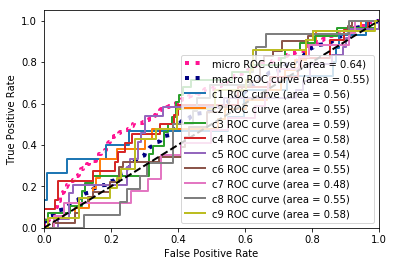

In [18]:
roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base)



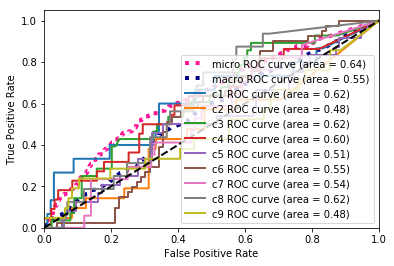

In [19]:
roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base)
